# 2 - Descriptive Statistics & Data Augmentation
This script generates descriptive statistics and adds features (columns) to a pre-processed time-series dataset containing hourly DayAhead Price, Demand, Fuel Price, Outages, Rt Price, Solar, & Wind data.  The new features are derived from the source data only - no new data is introduced here.  Finally, the most significant features (features that demonstrate ability to predict the target values) from both the source and new features are identified.

The objective of the larger process is to generate hourly forecasts for Day-Ahead (DA) and Real-Time (RT) Local Marginal Prices (LMP) of electrical generation (MWh) at the North Hub Bus. The process is divided in to the following sequence of notebooks (.ipynb format):

    1 - ETL - DA & RT LMP Forecast
    2 - Descriptive Statistics & Data Augmentation
    3 - Stationarity and Seasonality
    4 - ARIMA Time Series Models

The data used in this analysis is from January 1, 2022 through August 19, 2022.  The source data contains 5519 records with 47 columns and a datetime index, and includes null data points.  The data are almost entirely numeric. 

The script was originally written to handle a specific dataset.  However, it is built with flexibility that should permit the use of variable sets of time series and feature tabular data as long as they use the same structure as the original dataset.

Limitations
* The script does not identify trading strategies or any other application of the forecast
* The forecast algorithms are trained on less than one year of data and may not be adequately informed to forecast periods years in the future without training on newer data.

Copyright Matt Chmielewski<BR>
December 10, 2024<BR>
https://github.com/emskiphoto

## Objectives
1. Data augmentation - create additional time-series from source data to improve model
2. Calculate Descriptive statistics (4 moments) and distribution characteristics (normal, lognormal, gamma etc.) of the target variable
3. Principal Component Analysis - to remove excess time-series that are unlikely to improve model performance
4. Export 'ts_select.csv' and 'features_select.csv' files containing only selected features to local disk for use in the '3 - Stationarity and Seasonality' script.

## Observations
1. The potential benefit of data augmentation is the discovery of new time series(s) that yield better performance than the source data.  
2.  Augmented features/indicators are derived from source time-series through mathematical transformations
3.  A complete exploration of potential new features could include 100's to thousands of mathematical transformations.  Each of those transformations could involve a range of parameters that could further increase the total quantity of possible features.
4.  This script will add a limited number of features for demonstration purposes. 
5.  Some features do not have data in the Forecast period.  Augmented features will only be calculated with provided data, and no attempt will be made to forecast the values of any features other than the target time-series. 

## Load Python Dependencies

In [1]:
%matplotlib inline
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar  #holidays
import numpy as np
import pathlib
import datetime
import scipy
from scipy.signal import periodogram
# plotting libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# machine Learning libraries
from sklearn.preprocessing import StandardScaler # to scale Data
from sklearn.decomposition import PCA # Principal Components analysis

# load all parameters from custom config.py file
from config import *
# %run -i config.py
# load all custom functions from util.py file
from utils import *
# turn off Jedi for better auto-complete
%config IPCompleter.use_jedi=False

## Locations
Locations are designated in the 'config.py' file

In [2]:
data_dir, model_dir

(WindowsPath('C:/Users/user/OneDrive/python_envs/ERCOT_electricity_price_forecast/data'),
 WindowsPath('C:/Users/user/OneDrive/python_envs/ERCOT_electricity_price_forecast/model'))

## Parameters
Most Parameters are defined in config.py file.

In [3]:
pd.options.display.max_rows = 100
print(f'Timezone: {timezone}')
print(f'Maximum fraction of all records containing any NaN value:  {max_fraction_nan}')
print(f'maximum number of consecutive NaN values allowed to be imputed via interpolatation:  {n_max_consec_nans_interp}')

Timezone: US/Central
Maximum fraction of all records containing any NaN value:  0.05
maximum number of consecutive NaN values allowed to be imputed via interpolatation:  4


### Custom Functions
Stored in utils.py

## Load Data

### Load Features Table
This data will help categorize, filter and inventory features

In [8]:
file_features

WindowsPath('C:/Users/user/OneDrive/python_envs/ERCOT_electricity_price_forecast/data/features.csv')

In [9]:
df_features = pd.read_csv(file_features, index_col=0)
df_features.head()

Known Y/N  Solving For  Actual    Feature Type Category  \
Feature                                                                        
HB_NORTH (DALMP)         False         True   False  DayAhead Price    DALMP   
WZ_Coast (RTLOAD)        False        False    True          Demand   RTLOAD   
WZ_ERCOT (RTLOAD)        False        False    True          Demand   RTLOAD   
WZ_East (RTLOAD)         False        False    True          Demand   RTLOAD   
WZ_FarWest (RTLOAD)      False        False    True          Demand   RTLOAD   

                      Region  \
Feature                        
HB_NORTH (DALMP)       north   
WZ_Coast (RTLOAD)      coast   
WZ_ERCOT (RTLOAD)      ercot   
WZ_East (RTLOAD)        east   
WZ_FarWest (RTLOAD)  farwest   

                                                                 color  
Feature                                                                 
HB_NORTH (DALMP)     (0.7137254901960784, 0.7137254901960784, 0.847...  
WZ_Coast (RTLOAD)    (0.5796078431372549, 0.7701960784313725, 0.873...  
WZ_ERCOT (RTLOAD)    (0.5231372549019608, 0.73919261822376, 0.86154...  
WZ_East (RTLOAD)     (0.4666666666666667, 0.7081891580161477, 0.849...  
WZ_FarWest (RTLOAD)  (0.4120415224913495, 0.6771856978085352, 0.836...

### Load Processed Time Series data
The time-series feature data is the output of the "ETL" script which originated from the "POC Sample Data.xlsx" file.  At this point the time series has been split in to 'out-of-forecast' and 'in-forecast' files.   Load both files and merge to allow for creation of additional features in and out of the forecast time period.   

In [10]:
file_ts, file_ts_forecast

(WindowsPath('C:/Users/user/OneDrive/python_envs/ERCOT_electricity_price_forecast/data/ts.csv'),
 WindowsPath('C:/Users/user/OneDrive/python_envs/ERCOT_electricity_price_forecast/data/ts_forecast.csv'))

#### Load out-of forecast time series

In [11]:
df = pd.concat([pd.read_csv(file_, index_col=0, parse_dates=['DATETIME']) for
           file_ in [file_ts, file_ts_forecast]])
# df = pd.read_csv(file_ts, index_col=0, parse_dates=['DATETIME'])
df.index.freq = 'H'
df.head(3)

WZ_Coast (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                       
2022-01-01 07:00:00+00:00                         10307.0996   
2022-01-01 08:00:00+00:00                         10300.2002   
2022-01-01 09:00:00+00:00                         10313.0000   

                           WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                       
2022-01-01 07:00:00+00:00                         37308.3496   
2022-01-01 08:00:00+00:00                         36984.0036   
2022-01-01 09:00:00+00:00                         36764.8666   

                           WZ_East (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                      
2022-01-01 07:00:00+00:00                           1282.52   
2022-01-01 08:00:00+00:00                           1260.64   
2022-01-01 09:00:00+00:00                           1245.84   

                           WZ_FarWest (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                         
2022-01-01 07:00:00+00:00                            3657.7300   
2022-01-01 08:00:00+00:00                            3660.2400   
2022-01-01 09:00:00+00:00                            3668.4399   

                           WZ_North (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                       
2022-01-01 07:00:00+00:00                            819.630   
2022-01-01 08:00:00+00:00                            759.254   
2022-01-01 09:00:00+00:00                            725.907   

                           WZ_NorthCentral (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                              
2022-01-01 07:00:00+00:00                                10433.5000   
2022-01-01 08:00:00+00:00                                10346.5996   
2022-01-01 09:00:00+00:00                                10346.5996   

                           WZ_SouthCentral (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                              
2022-01-01 07:00:00+00:00                                 6365.8901   
2022-01-01 08:00:00+00:00                                 6287.0098   
2022-01-01 09:00:00+00:00                                 6146.4502   

                           WZ_Southern (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                          
2022-01-01 07:00:00+00:00                             2852.1899   
2022-01-01 08:00:00+00:00                             2842.3000   
2022-01-01 09:00:00+00:00                             2785.6599   

                           WZ_West (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                      
2022-01-01 07:00:00+00:00                           1589.79   
2022-01-01 08:00:00+00:00                           1527.76   
2022-01-01 09:00:00+00:00                           1532.97   

                           ERCOT (WIND_STWPF_BIDCLOSE)  \
DATETIME                                                 
2022-01-01 07:00:00+00:00                      16698.4   
2022-01-01 08:00:00+00:00                      17210.4   
2022-01-01 09:00:00+00:00                      18276.7   

                           GR_COASTAL (WIND_STWPF_BIDCLOSE)  \
DATETIME                                                      
2022-01-01 07:00:00+00:00                            4360.7   
2022-01-01 08:00:00+00:00                            4370.5   
2022-01-01 09:00:00+00:00                            4357.7   

                           GR_ERCOT (WIND_STWPF_BIDCLOSE)  \
DATETIME                                                    
2022-01-01 07:00:00+00:00                         16698.4   
2022-01-01 08:00:00+00:00                         17210.4   
2022-01-01 09:00:00+00:00                         18276.7   

                           GR_NORTH (WIND_STWPF_BIDCLOSE)  \
DATETIME                                                    
2022-01-01 07:00:0

In [12]:
df.tail(3)

WZ_Coast (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                       
2022-08-19 03:00:00+00:00                         16821.0996   
2022-08-19 04:00:00+00:00                         15956.9004   
2022-08-19 05:00:00+00:00                         15032.0000   

                           WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                       
2022-08-19 03:00:00+00:00                         62122.4999   
2022-08-19 04:00:00+00:00                         58237.7999   
2022-08-19 05:00:00+00:00                         54260.6896   

                           WZ_East (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                      
2022-08-19 03:00:00+00:00                           2269.74   
2022-08-19 04:00:00+00:00                           2105.77   
2022-08-19 05:00:00+00:00                           1934.14   

                           WZ_FarWest (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                         
2022-08-19 03:00:00+00:00                            5067.2598   
2022-08-19 04:00:00+00:00                            4939.5898   
2022-08-19 05:00:00+00:00                            4822.8301   

                           WZ_North (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                       
2022-08-19 03:00:00+00:00                          1553.4200   
2022-08-19 04:00:00+00:00                          1447.1500   
2022-08-19 05:00:00+00:00                          1342.9301   

                           WZ_NorthCentral (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                              
2022-08-19 03:00:00+00:00                                18971.3008   
2022-08-19 04:00:00+00:00                                17435.5000   
2022-08-19 05:00:00+00:00                                15946.5000   

                           WZ_SouthCentral (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                              
2022-08-19 03:00:00+00:00                                10973.2998   
2022-08-19 04:00:00+00:00                                10213.7998   
2022-08-19 05:00:00+00:00                                 9412.5195   

                           WZ_Southern (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                          
2022-08-19 03:00:00+00:00                             4858.8599   
2022-08-19 04:00:00+00:00                             4578.1299   
2022-08-19 05:00:00+00:00                             4288.1099   

                           WZ_West (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                      
2022-08-19 03:00:00+00:00                           1607.52   
2022-08-19 04:00:00+00:00                           1560.96   
2022-08-19 05:00:00+00:00                           1481.66   

                           ERCOT (WIND_STWPF_BIDCLOSE)  \
DATETIME                                                 
2022-08-19 03:00:00+00:00                       5848.0   
2022-08-19 04:00:00+00:00                       5827.4   
2022-08-19 05:00:00+00:00                       5527.3   

                           GR_COASTAL (WIND_STWPF_BIDCLOSE)  \
DATETIME                                                      
2022-08-19 03:00:00+00:00                            1087.1   
2022-08-19 04:00:00+00:00                            1137.5   
2022-08-19 05:00:00+00:00                            1187.4   

                           GR_ERCOT (WIND_STWPF_BIDCLOSE)  \
DATETIME                                                    
2022-08-19 03:00:00+00:00                          5848.0   
2022-08-19 04:00:00+00:00                          5827.4   
2022-08-19 05:00:00+00:00                          5527.3   

                           GR_NORTH (WIND_STWPF_BIDCLOSE)  \
DATETIME                                                    
2022-08-19 03:00:0

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5519 entries, 2022-01-01 07:00:00+00:00 to 2022-08-19 05:00:00+00:00
Freq: H
Data columns (total 48 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   WZ_Coast (BIDCLOSE_LOAD_FORECAST)         5519 non-null   float64
 1   WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)         5519 non-null   float64
 2   WZ_East (BIDCLOSE_LOAD_FORECAST)          5519 non-null   float64
 3   WZ_FarWest (BIDCLOSE_LOAD_FORECAST)       5519 non-null   float64
 4   WZ_North (BIDCLOSE_LOAD_FORECAST)         5519 non-null   float64
 5   WZ_NorthCentral (BIDCLOSE_LOAD_FORECAST)  5519 non-null   float64
 6   WZ_SouthCentral (BIDCLOSE_LOAD_FORECAST)  5519 non-null   float64
 7   WZ_Southern (BIDCLOSE_LOAD_FORECAST)      5519 non-null   float64
 8   WZ_West (BIDCLOSE_LOAD_FORECAST)          5519 non-null   float64
 9   ERCOT (WIND_STWPF_BIDCLOSE)               5519 non-

### Designate in- and out- of forecast periods
The majority of the dataset is known historical data with defined target feature values.  A small part of the data does not have defined target feature values and is intended to be used as test data to evaluate model performance.  Source data was processed such that there are non null values in the in_forecast period.

* in_forecast = 'historical'
* out_forecast = 'forecast'

Note that the target features have different forecast period durations.

In [14]:
feature_forecast_start = {col_ : df[col_].isna().idxmax() for col_ in cols_target}
feature_forecast_start

{'HB_NORTH (DALMP)': Timestamp('2022-08-17 06:00:00+0000', tz='UTC', freq='H'),
 'HB_NORTH (RTLMP)': Timestamp('2022-08-15 20:00:00+0000', tz='UTC', freq='H')}

In [15]:
in_forecast = df['forecast']
out_forecast = ~df['forecast']
# Consider this flexible Forecast start by target feature:
# df.last('M').index[df.last('M')[col_].isna()][0]
start_historical, end_historical = df.index.min(), df.loc[out_forecast].index[-1]
start_forecast, end_forecast = in_forecast[in_forecast].index[0], in_forecast[in_forecast].index[-1]
assert df.loc[in_forecast].notnull().any().any()
start_historical, end_historical, start_forecast, end_forecast

(Timestamp('2022-01-01 07:00:00+0000', tz='UTC', freq='H'),
 Timestamp('2022-08-15 19:00:00+0000', tz='UTC', freq='H'),
 Timestamp('2022-08-15 20:00:00+0000', tz='UTC', freq='H'),
 Timestamp('2022-08-19 05:00:00+0000', tz='UTC', freq='H'))

#### Create list of native/source features (included with original dataset)

In [16]:
features_source = df.columns.intersection(df_features.index)
features_source_added = df.columns.difference(features_source)
print(f'There are {len(features_source)} features from original source:\n\n {sorted(features_source)}')

There are 42 features from original source:

 ['ERCOT (GENERATION_SOLAR_RT)', 'ERCOT (SOLAR_STPPF_BIDCLOSE)', 'ERCOT (TOTAL_RESOURCE_CAP_OUT)', 'ERCOT (WIND_STWPF_BIDCLOSE)', 'GR_COASTAL (WINDDATA)', 'GR_COASTAL (WIND_STWPF_BIDCLOSE)', 'GR_ERCOT (WINDDATA)', 'GR_ERCOT (WIND_STWPF_BIDCLOSE)', 'GR_NORTH (WINDDATA)', 'GR_NORTH (WIND_STWPF_BIDCLOSE)', 'GR_PANHANDLE (WINDDATA)', 'GR_PANHANDLE (WIND_STWPF_BIDCLOSE)', 'GR_SOUTH (WINDDATA)', 'GR_SOUTH (WIND_STWPF_BIDCLOSE)', 'GR_WEST (WINDDATA)', 'GR_WEST (WIND_STWPF_BIDCLOSE)', 'HB_NORTH (DALMP)', 'HB_NORTH (RTLMP)', 'Henry (GASPRICE)', 'Katy (GASPRICE)', 'NORTH (ERCOT) (WIND_STWPF_BIDCLOSE)', 'SOUTH_HOUSTON (WIND_STWPF_BIDCLOSE)', 'WEST (ERCOT) (WIND_STWPF_BIDCLOSE)', 'WEST_NORTH (WIND_STWPF_BIDCLOSE)', 'WZ_Coast (BIDCLOSE_LOAD_FORECAST)', 'WZ_Coast (RTLOAD)', 'WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)', 'WZ_ERCOT (RTLOAD)', 'WZ_East (BIDCLOSE_LOAD_FORECAST)', 'WZ_East (RTLOAD)', 'WZ_FarWest (BIDCLOSE_LOAD_FORECAST)', 'WZ_FarWest (RTLOAD)', 'WZ_Nort

In [17]:
print(f'There are {len(features_source_added)} features added to original '
      f'source prior to this script:\n\n {sorted(features_source_added)}')

There are 6 features added to original source prior to this script:

 ['DATETIME_LOCAL', 'HOURENDING', 'MARKETDAY', 'MONTH', 'YEAR', 'forecast']


### Identify Features Missing in Forecast Period
The primary objective is to forecast the target features during the Forecast Period.   Several Approaches will be attempted including some that will only use the target feature as well as others that will use multiple additional features (exogenous).  

Features that have no data during the Forecast period cannot be used as inputs to an algorithm during the forecast period _without also being forecast alongside the target feature_.  It is possible to forecast the missing exogenous data and then use it as input to predict the target feature.  However, this approach is intentionally omitted.  For this reason only exogenous features that report data during the forecast period are identified.  All features will be evaluated for feature significance, however only variables available during the forecast will be augmented.

#### Is the count of complete exogenous features in Forecast period the same for all Targets? 

In [18]:
counts_ = []
features_available_forecast = dict.fromkeys(cols_target)
for col_ in cols_target:
    print(f'Count of Features with valid data during Forecast Period of "{col_}"')
    display(df.loc[df[col_].isna(), df_features.index].notnull().all().value_counts())
    bool_ = df.loc[df[col_].isna(), df_features.index].notnull().all()
    cols_exog_valid_forecast = df[df_features.index].columns[bool_].tolist()
    features_available_forecast[col_] = cols_exog_valid_forecast
    counts_.append(df.loc[df[col_].isna(), df_features.index].notnull().all().sum())

if [counts_[0]]*len(counts_) == counts_:
    print(f'Count of valid exogenous features in forecast is {counts_[0]} and is the same '
         f'for target features {", ".join(cols_target)}')

Count of Features with valid data during Forecast Period of "HB_NORTH (DALMP)"


True     22
False    20
dtype: int64

Count of Features with valid data during Forecast Period of "HB_NORTH (RTLMP)"


True     22
False    20
dtype: int64

Count of valid exogenous features in forecast is 22 and is the same for target features HB_NORTH (DALMP), HB_NORTH (RTLMP)


In [19]:
# list of features that have data in forecast for all target features
cols_valid_in_forecast = df_features.index.intersection(list(set([item for sublist in [l for
                           l in features_available_forecast.values()] for
                           item in sublist]))).tolist()
print(f'These Features are available during the Forecast period:\n\n'
      f'{", ".join(cols_valid_in_forecast)}')

These Features are available during the Forecast period:

WZ_Coast (BIDCLOSE_LOAD_FORECAST), WZ_ERCOT (BIDCLOSE_LOAD_FORECAST), WZ_East (BIDCLOSE_LOAD_FORECAST), WZ_FarWest (BIDCLOSE_LOAD_FORECAST), WZ_North (BIDCLOSE_LOAD_FORECAST), WZ_NorthCentral (BIDCLOSE_LOAD_FORECAST), WZ_SouthCentral (BIDCLOSE_LOAD_FORECAST), WZ_Southern (BIDCLOSE_LOAD_FORECAST), WZ_West (BIDCLOSE_LOAD_FORECAST), ERCOT (TOTAL_RESOURCE_CAP_OUT), ERCOT (SOLAR_STPPF_BIDCLOSE), ERCOT (WIND_STWPF_BIDCLOSE), GR_COASTAL (WIND_STWPF_BIDCLOSE), GR_ERCOT (WIND_STWPF_BIDCLOSE), GR_NORTH (WIND_STWPF_BIDCLOSE), GR_PANHANDLE (WIND_STWPF_BIDCLOSE), GR_SOUTH (WIND_STWPF_BIDCLOSE), GR_WEST (WIND_STWPF_BIDCLOSE), NORTH (ERCOT) (WIND_STWPF_BIDCLOSE), SOUTH_HOUSTON (WIND_STWPF_BIDCLOSE), WEST (ERCOT) (WIND_STWPF_BIDCLOSE), WEST_NORTH (WIND_STWPF_BIDCLOSE)


#### Visualize Features Available in Forecast Period
These features are already available for inputs for prediction.

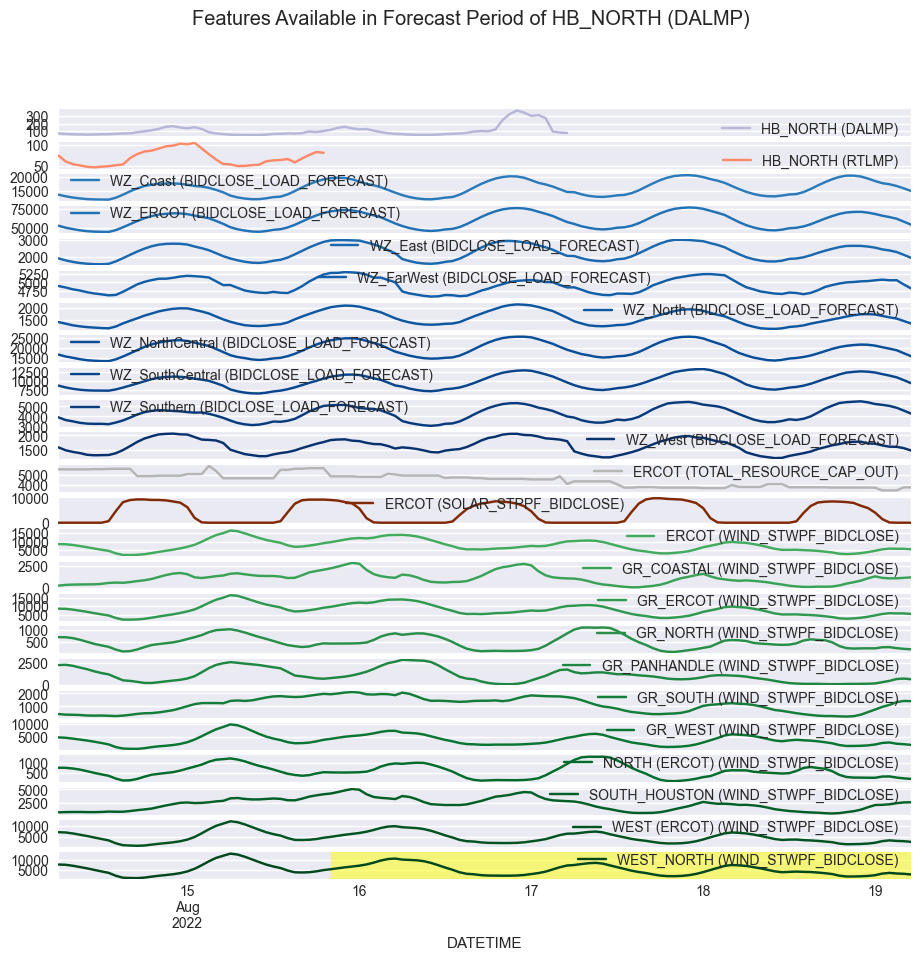

In [20]:
use_cols_ = cols_target + features_available_forecast[cols_target[0]]
df.last('W').loc[:, use_cols_].plot(subplots=True, figsize=(11,10),
            title=f'Features Available in Forecast Period of {cols_target[0]}',
         color=[colors_features[c] if c in colors_features else 'grey' for c in use_cols_])
plt.axvspan(df.index[df['forecast']][0], df.index[df['forecast']][-1],
            color='yellow', label='forecast', alpha=0.5)
plt.show()

#### Visualize Count of NaN values in Time-Series Data by Date

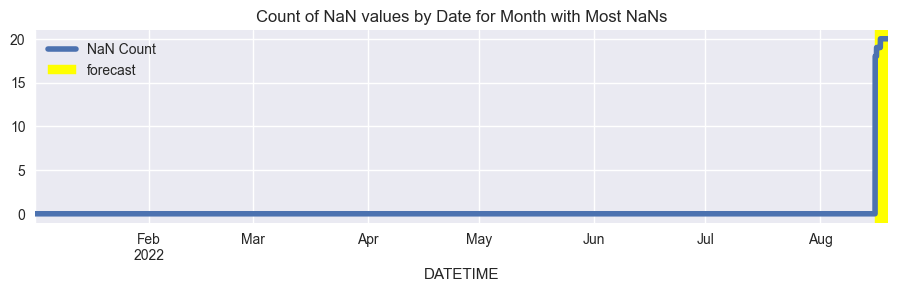

In [21]:
df.isna().sum(1).plot(lw=4, label='NaN Count', figsize = [11,2.5])
# if month_max_nan in idx_forecast.month:
plt.axvspan(df.index[df['forecast']][0], df.index[df['forecast']][-1],
            color='yellow', label='forecast')
plt.title('Count of NaN values by Date for Month with Most NaNs')
plt.legend()
plt.show()

#### Visualize Full Range of Target Time Series and Forecast Period

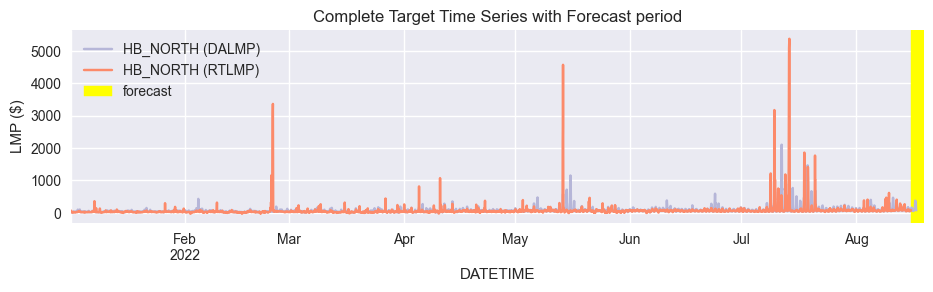

In [22]:
df[cols_target].plot(color = colors_target, figsize = [11,2.5], ylabel='LMP ($)')
plt.axvspan(start_forecast, end_forecast, color='yellow', label='forecast')
plt.title('Complete Target Time Series with Forecast period')
plt.legend()
plt.show()

#### Visualize Detailed Target Time Series and Forecast Period Excluding Outliers

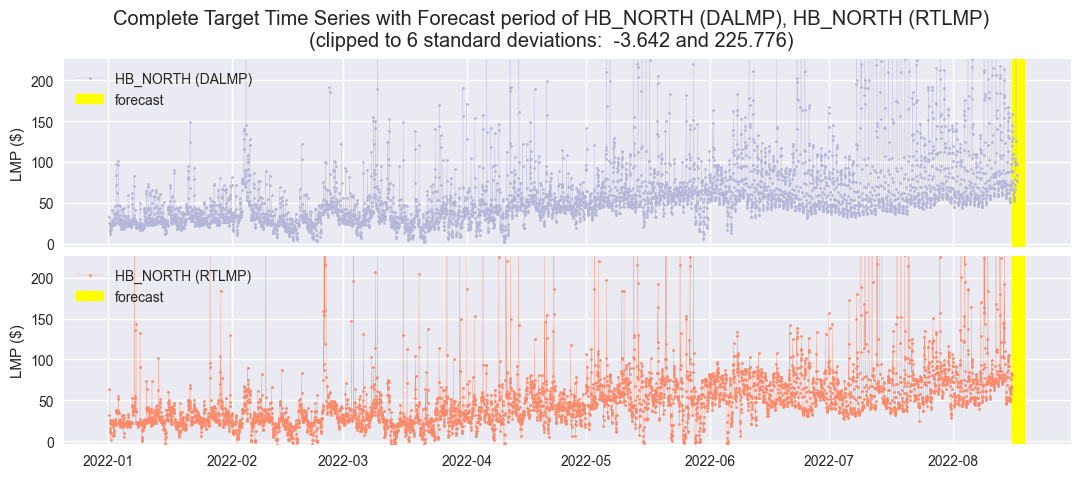

In [23]:
# calculate y_limits
n_std_ = 6
y_min_std, y_max_std = min_max_std_asymmetric(df[cols_target].stack(),n_std_)
# initiate 2 axis figure
fig, ax = plt.subplots(len(cols_target),1,
            figsize = (13,5), sharex=True, gridspec_kw={'hspace': 0.05})
title = (f'Complete Target Time Series with Forecast period of {", ".join(cols_target)}\n'
         f'(clipped to {n_std_} standard deviations:  {round(y_min_std,3)} and {round(y_max_std,3)})')
for ax_, col_ in zip(ax.flatten(), cols_target):
    ax_.plot(df[col_], color = colors_target[col_], lw=0.2, marker='o', markersize=2, label=col_)
    ax_.set_ylim(y_min_std, y_max_std)
    ax_.axvspan(start_forecast, end_forecast, color='yellow', label='forecast')
    ax_.set_ylabel('LMP ($)')
    ax_.legend()

fig.suptitle(title)
plt.show()

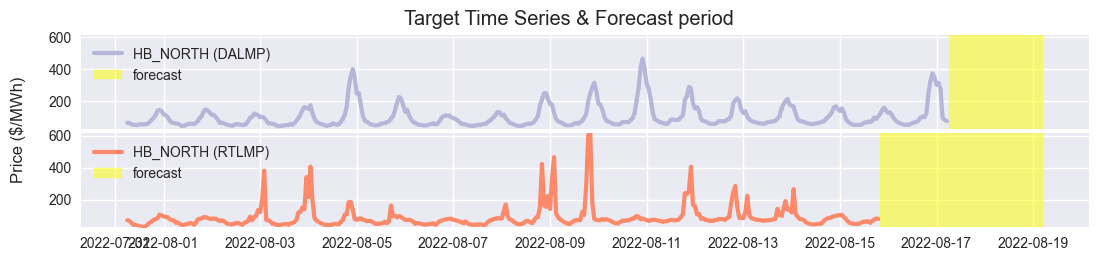

In [24]:
n_std_ = 6
# y_min_std, y_max_std = min_max_std_symmetric(df.last('M')[cols_target].stack(),n_std_)
y_min_std, y_max_std = df.last('M')[cols_target].stack().agg([min, max]).values
fig, ax = plt.subplots(2,1,figsize = (13,2.5), sharex=True, gridspec_kw={'hspace': 0.05})
title = (f'Target Time Series & Forecast period'
#          f'(clipped to {n_std_} standard deviations:  {round(y_min_std,3)} and {round(y_max_std,3)})'
        )
for ax_, col_ in zip(ax.flatten(), cols_target):
    ax_.plot(df.last('M')[col_], color = colors_features[col_], 
                    lw=3, marker='o', markersize=2, label=col_)
    ax_.set_ylim(y_min_std, y_max_std)
    ax_.axvspan(feature_forecast_start[col_], end_forecast, color='yellow', label='forecast', alpha=0.5)
    ax_.legend(loc='upper left')
# plt.ylim(y_min_std, y_max_std)
# fig.suptitle('Complete Target Time Series with Forecast period')
fig.suptitle(title)
fig.supylabel('Price ($/MWh)', x=0.07)
plt.show()

#### Visualize Distribution of Target Features

In [25]:
# n_std_ = 6
# fig, ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=(11,6))
# # calculate minimum and maximum value for all target columns and set limits at 3 std
# x_min_std, x_max_std = min_max_std_symmetric(df[cols_target].stack(),n_std_)
# for ax_, col, color in zip(ax.flatten(), cols_target, colors_target.values()):
# #     ax.hist(df[col], bins=50)
#     ax_.hist(df[col].clip(x_min_std, x_max_std), bins=100, color=color, rwidth=0.8,
#              alpha=0.8, label=col)
#     ax_.legend()
#     ax_.axvline(0, color='black', lw=0.5, linestyle=':')
# #     sns.ecdfplot(df[col].clip(x_min_std, x_max_std), color=color, lw=4, ax=ax)
# # sns.ecdfplot(rt_lmp.clip(x_min_std, x_max_std), color=color_rt_lmp, lw=4, ax=ax)
# plt.xlabel('Count')

# plt.grid(axis='both', linewidth=1)
# fig.suptitle(f'Histograms of {", ".join(cols_target)}\n'
#          f'(clipped to {n_std_} standard deviations:  {round(x_min_std,3)} and {round(x_max_std,3)})')
# fig.supylabel('Values', x=0.05)
# plt.show()

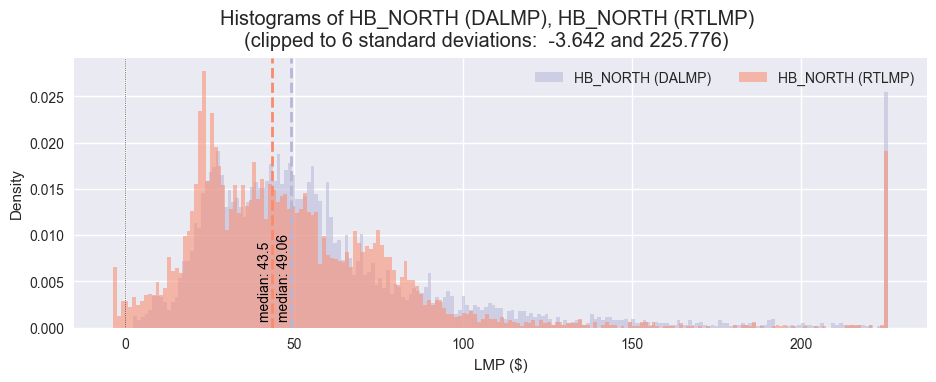

In [27]:
n_std_ = 6
# fig, ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=(11,6))
fig, ax = plt.subplots(figsize=(11,3.5))
# calculate minimum and maximum value for all target columns and set limits at 3 std
x_min_std, x_max_std = min_max_std_asymmetric(df[cols_target].stack(),n_std_)
# for ax_, col, color in zip(ax.flatten(), cols_target, colors_target.values()):
for col_ in cols_target:
    x_ = df[col_].dropna().clip(x_min_std, x_max_std)
    x_median_ = round(np.median(x_),2)
    color_ = colors_target[col_]
    ax.axvline(x_median_, color=color_, lw=2,linestyle='--')
    
    ax.hist(x_, bins=200, color=color_, rwidth=1, density=True,
             alpha=0.55, label=col_)
    ax.text(x_median_, 0.001, f'median: {x_median_}', rotation=90, color='black', ha='right')
ax.legend(ncol=2)
ax.axvline(0, color='black', lw=0.5, linestyle=':')
ax.set_xlabel('LMP ($)')
ax.set_ylabel('Density')
ax.grid(axis='both', linewidth=1)
fig.suptitle(f'Histograms of {", ".join(cols_target)}\n'
         f'(clipped to {n_std_} standard deviations:  {round(x_min_std,3)} and {round(x_max_std,3)})', y=1.02)
plt.show()

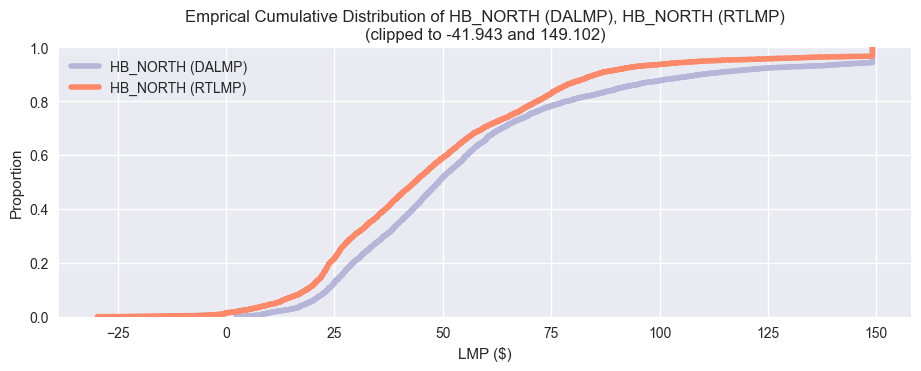

In [28]:
fig, ax = plt.subplots(sharex=True, figsize=(11,3.5))
# calculate minimum and maximum value for all target columns and set limits at 3 std
x_min_std3, x_max_std3 = min_max_std_symmetric(df[cols_target].stack(),3)
for col, color in zip(cols_target, colors_target.values()):

    sns.ecdfplot(df[col].clip(x_min_std3, x_max_std3), color=color, lw=4, ax=ax)
# sns.ecdfplot(rt_lmp.clip(x_min_std3, x_max_std3), color=color_rt_lmp, lw=4, ax=ax)
plt.xlabel('LMP ($)')
plt.legend(cols_target)
ax.grid(axis='both', linewidth=1)
plt.title(f'Emprical Cumulative Distribution of {", ".join(cols_target)}\n'
         f'(clipped to {round(x_min_std3,3)} and {round(x_max_std3,3)})')
plt.show()

Observations:
1. Target time series have fat-tails (significant count of extreme values)
2. Roughly 95% of all values are between 0 and 100.
3. Real Time pricing (RTLMP) has some negative values and Day-Ahead pricing does not.

## Descriptive Statistics
Calculate traditional, single-value statistics for each feature using out-of-forecast data only and store by feature in df_features.  Several Python packages can be used for this process.  In the interest of simplicity and transparency only Scipy and Pandas are used. 

### Static Single-Value Statistics

In [29]:
stats_ = [min, pd.DataFrame.mean, pd.DataFrame.median,
          max, pd.DataFrame.std, pd.DataFrame.var, pd.DataFrame.kurtosis, 
         pd.DataFrame.skew]
df_stats1 = df.loc[out_forecast, features_source].agg(stats_).T.round(2)
# df_stats1 = df.loc[:, features_source].agg(stats_).T
df_stats1.head(2)

min      mean    median       max  \
WZ_Coast (BIDCLOSE_LOAD_FORECAST)   8770.70  13543.25  12710.30  21272.40   
WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)  30359.95  50131.07  47299.57  81430.82   

                                        std           var  kurt  skew  
WZ_Coast (BIDCLOSE_LOAD_FORECAST)   2879.09  8.289177e+06 -0.32  0.79  
WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)  11614.80  1.349037e+08 -0.30  0.75

In [30]:
qtiles = [0.001,0.025,0.05,0.25,0.5,0.75,0.95, 0.975, 0.999]
cols_qtiles = [f'{x*100}th_ptile' for x in qtiles]
df_stats2 = df.loc[out_forecast, features_source].quantile(qtiles).T.round(2)
# df_stats2 = df.loc[:, features_source].quantile(qtiles).T
df_stats2.columns = cols_qtiles
df_stats2.head(2)

0.1th_ptile  2.5th_ptile  5.0th_ptile  \
WZ_Coast (BIDCLOSE_LOAD_FORECAST)      8875.04      9457.83      9818.57   
WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)     31029.81     33373.90     35015.64   

                                   25.0th_ptile  50.0th_ptile  75.0th_ptile  \
WZ_Coast (BIDCLOSE_LOAD_FORECAST)      11512.90      12710.30      15273.60   
WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)      41479.08      47299.57      56746.57   

                                   95.0th_ptile  97.5th_ptile  99.9th_ptile  
WZ_Coast (BIDCLOSE_LOAD_FORECAST)      19365.48      19973.35      20973.17  
WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)      73840.92      76002.09      80755.06

In [31]:
cols_feature_source = df_features.columns
df_features = pd.concat([df_features, df_stats1, df_stats2], axis=1)
cols_feature_stats = df_features.columns.difference(cols_feature_source)
df_features.head(2)

Known Y/N  Solving For  Actual    Feature Type Category  \
HB_NORTH (DALMP)       False         True   False  DayAhead Price    DALMP   
WZ_Coast (RTLOAD)      False        False    True          Demand   RTLOAD   

                  Region                                              color  \
HB_NORTH (DALMP)   north  (0.7137254901960784, 0.7137254901960784, 0.847...   
WZ_Coast (RTLOAD)  coast  (0.5796078431372549, 0.7701960784313725, 0.873...   

                       min      mean    median       max      std         var  \
HB_NORTH (DALMP)      2.37     66.51     48.86   2100.11    89.43     7997.93   
WZ_Coast (RTLOAD)  8749.86  13568.04  12843.12  21081.94  2853.44  8142113.73   

                     kurt  skew  0.1th_ptile  2.5th_ptile  5.0th_ptile  \
HB_NORTH (DALMP)   155.64  9.95         3.12        13.85        18.71   
WZ_Coast (RTLOAD)   -0.37  0.75      8914.59      9531.52      9876.30   

                   25.0th_ptile  50.0th_ptile  75.0th_ptile  95.0th_ptile  \
HB_NORTH (DALMP)          32.72         48.86         69.79        158.06   
WZ_Coast (RTLOAD)      11461.70      12843.12      15336.65      19286.96   

                   97.5th_ptile  99.9th_ptile  
HB_NORTH (DALMP)         241.01       1260.44  
WZ_Coast (RTLOAD)      19924.83      20961.93

### Which Theoretical Distribution Type Best Represents Each Feature?
This can be used to guide the process of making a time-series feature stationary

In [32]:
# which distribution types should be evaluated?
dist_names = ["weibull_min", "norm", "weibull_max", "beta",
              "invgauss", "uniform", "gamma", "expon",   
              "lognorm", "pearson3","triang"]

In [33]:
results_ = []
pctile_min, pctile_max = 0.005, 0.995

for col_ in df_features.index: 
    # due to fat-tailed distribution, use relatively extreme quantile values for clipping outliers
    y_min_, y_max_ = df.loc[out_forecast, col_].quantile([0.005, 0.995]).values
    y_std = df.loc[out_forecast, col_].clip(y_min_, y_max_)
    size = len(y_std)
    chi_square_statistics = []
    # 11 equi-distant bins of observed Data 
    percentile_bins = np.linspace(0,100,11)
    percentile_cutoffs = np.percentile(y_std, percentile_bins)
    observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
    cum_observed_frequency = np.cumsum(observed_frequency)

    # Loop through possible distributions
    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(y_std)
#         print("{}\n{}\n".format(dist, param))


        # Get expected counts in percentile bins
        # cdf of fitted distribution across bins
        cdf_fitted = dist.cdf(percentile_cutoffs, *param)
        expected_frequency = []
        for bin in range(len(percentile_bins)-1):
            expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
            expected_frequency.append(expected_cdf_area)

        # Chi-square Statistics
        expected_frequency = np.array(expected_frequency) * size
        cum_expected_frequency = np.cumsum(expected_frequency)
        ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
        chi_square_statistics.append(ss)

    #Sort by minimum chi-square statistics
    results = pd.DataFrame()
    results['Distribution'] = dist_names
    results['chi_square'] = chi_square_statistics
    results.sort_values(['chi_square'], inplace=True)
    results_.append(results)
#     print ('\nDistributions listed by Betterment of fit:')
#     print ('............................................')
#     print (results)
df_results = pd.concat(results_, keys=df_features.index, axis=0, names=['Feature', 'Rank'])\
                .droplevel(1, axis=0)

In [36]:
df_results.head(3)

Distribution  chi_square
Feature                                  
HB_NORTH (DALMP)      lognorm  128.932624
HB_NORTH (DALMP)     invgauss  207.576664
HB_NORTH (DALMP)         beta  465.857821

In [37]:
# identify Distribution that has lowest chi square score for each target feature
# and is deemed to be the closest match to theoretical distributions
df_distributions = df_results.reset_index().set_index('Distribution').groupby('Feature')\
    .idxmin().rename(columns={'chi_square': 'Distribution'})
df_distributions.head(3)

Distribution
Feature                                    
ERCOT (GENERATION_SOLAR_RT)           gamma
ERCOT (SOLAR_STPPF_BIDCLOSE)            NaN
ERCOT (TOTAL_RESOURCE_CAP_OUT)     invgauss

#### Count of Distribution Types for all features

In [38]:
df_features = df_features.join(df_distributions)
df_features['Distribution'].value_counts()

beta           16
gamma          10
pearson3        5
lognorm         3
uniform         3
triang          2
weibull_min     1
invgauss        1
Name: Distribution, dtype: int64

In [39]:
# create dictionary containing distribution type by feature name
feature_distribution_type = df_results.reset_index().set_index('Distribution')\
        .groupby('Feature').idxmin().to_dict()['chi_square']
# feature_distribution_type

#### Table of Distribution type by Feature

In [40]:
cols_distribution_stats = ['Distribution'] + df_stats1.columns.tolist() + [cols_qtiles[1], cols_qtiles[-2]]
df_features[cols_distribution_stats].sort_index()

Distribution       min      mean  \
ERCOT (GENERATION_SOLAR_RT)                     gamma     -0.64   2865.48   
ERCOT (SOLAR_STPPF_BIDCLOSE)                      NaN      0.00   3266.95   
ERCOT (TOTAL_RESOURCE_CAP_OUT)               invgauss   3697.00  12264.41   
ERCOT (WIND_STWPF_BIDCLOSE)                      beta    429.00  14229.14   
GR_COASTAL (WINDDATA)                            beta      0.00   1800.16   
GR_COASTAL (WIND_STWPF_BIDCLOSE)                 beta      5.60   1930.38   
GR_ERCOT (WINDDATA)                              beta    307.60  13577.02   
GR_ERCOT (WIND_STWPF_BIDCLOSE)                   beta    429.00  14229.12   
GR_NORTH (WINDDATA)                              beta     -0.69   1012.76   
GR_NORTH (WIND_STWPF_BIDCLOSE)                   beta      0.20   1020.03   
GR_PANHANDLE (WINDDATA)                       uniform      0.27   2004.37   
GR_PANHANDLE (WIND_STWPF_BIDCLOSE)            uniform      8.40   2057.01   
GR_SOUTH (WINDDATA)                              beta     -0.78   1655.79   
GR_SOUTH (WIND_STWPF_BIDCLOSE)                   beta     15.70   1759.44   
GR_WEST (WINDDATA)                            uniform      1.13   7103.94   
GR_WEST (WIND_STWPF_BIDCLOSE)                    beta     83.20   7462.26   
HB_NORTH (DALMP)                              lognorm      2.37     66.51   
HB_NORTH (RTLMP)                              lognorm    -29.70     65.94   
Henry (GASPRICE)                                 beta      3.58      6.31   
Katy (GASPRICE)                                  beta      3.40      6.03   
NORTH (ERCOT) (WIND_STWPF_BIDCLOSE)              beta      0.20   1075.51   
SOUTH_HOUSTON (WIND_STWPF_BIDCLOSE)              beta     47.20   3645.02   
WEST (ERCOT) (WIND_STWPF_BIDCLOSE)               beta    190.00   9508.61   
WEST_NORTH (WIND_STWPF_BIDCLOSE)                 beta    292.20  10584.12   
WZ_Coast (BIDCLOSE_LOAD_FORECAST)            pearson3   8770.70  13543.25   
WZ_Coast (RTLOAD)                               gamma   8749.86  13568.04   
WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)               gamma  30359.95  50131.07   
WZ_ERCOT (RTLOAD)                               gamma  31955.06  50359.64   
WZ_East (BIDCLOSE_LOAD_FORECAST)                gamma   1035.16   1904.29   
WZ_East (RTLOAD)                                gamma    828.82   1871.24   
WZ_FarWest (BIDCLOSE_LOAD_FORECAST)             gamma   3117.00   4492.57   
WZ_FarWest (RTLOAD)                          pearson3   3605.08   4549.59   
WZ_North (BIDCLOSE_LOAD_FORECAST)             lognorm    354.99   1304.42   
WZ_North (RTLOAD)                            pearson3    707.09   1309.81   
WZ_NorthCentral (BIDCLOSE_LOAD_FORECAST)        gamma   7821.29  15235.43   
WZ_NorthCentral (RTLOAD)                        gamma   8067.61  15224.08   
WZ_SouthCentral (BIDCLOSE_LOAD_FORECAST)     pearson3   4220.47   8201.05   
WZ_SouthCentral (RTLOAD)                     pearson3   4832.03   8320.56   
WZ_Southern (BIDCLOSE_LOAD_FORECAST)           triang   2223.62   3929.68   
WZ_Southern (RTLOAD)                           triang   2327.06   3982.30   
WZ_West (BIDCLOSE_LOAD_FORECAST)          weibull_min    891.37   1520.37   
WZ_West (RTLOAD)                                gamma    707.45   1534.02   

                                            median       max       std  \
ERCOT (GENERATION_SOLAR_RT)                 409.17   9702.52   3410.83   
ERCOT (SOLAR_STPPF_BIDCLOSE)                430.70  10020.30   3790.18   
ERCOT (TOTAL_RESOURCE_CAP_OUT)             9319.00  25631.00   6937.88   
ERCOT (WIND_STWPF_BIDCLOSE)               13964.80  30451.80   7157.91   
GR_COASTAL (WINDDATA)                      1747.19   3948.05   1142.21   
GR_COASTAL (WIND_STWPF_BIDCLOSE)           1707.60   4708.30   1293.64   
GR_ERCOT (WINDDATA)                       13898.39  26859.39   6440.08   
GR_ERCOT (WIND_STWPF_BIDCLOSE)            13964.80  30451.80   7157.89   
GR_NORTH (WINDDATA)                         983.42   2213.84   

Descriptive Statistics, Moments, & Boxplots of all Features


Distribution   min   mean median      max    std      var  \
HB_NORTH (DALMP)      lognorm  2.37  66.51  48.86  2100.11  89.43  7997.93   

                    kurt  skew 2.5th_ptile 97.5th_ptile  
HB_NORTH (DALMP)  155.64  9.95       13.85       241.01

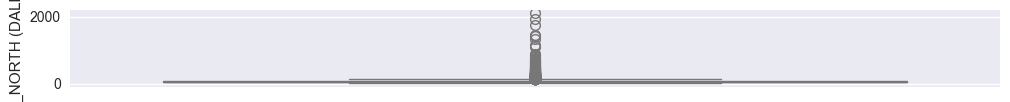

Distribution      min      mean    median       max  \
WZ_Coast (RTLOAD)        gamma  8749.86  13568.04  12843.12  21081.94   

                       std         var  kurt  skew 2.5th_ptile 97.5th_ptile  
WZ_Coast (RTLOAD)  2853.44  8142113.73 -0.37  0.75     9531.52     19924.83

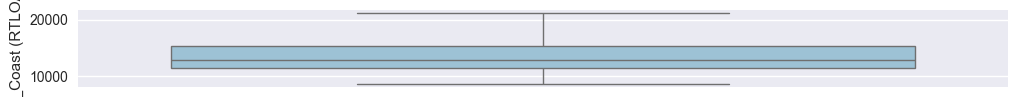

Distribution       min      mean    median       max  \
WZ_ERCOT (RTLOAD)        gamma  31955.06  50359.64  47656.77  79827.91   

                        std           var  kurt  skew 2.5th_ptile 97.5th_ptile  
WZ_ERCOT (RTLOAD)  11211.23  125691585.64 -0.38  0.72    34240.73     75262.05

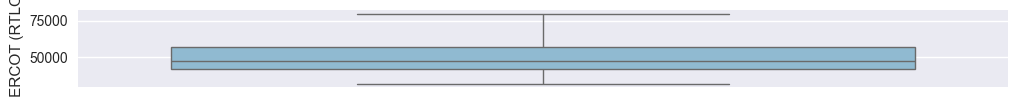

Distribution     min     mean   median      max    std  \
WZ_East (RTLOAD)        gamma  828.82  1871.24  1769.64  3113.53  472.5   

                        var kurt  skew 2.5th_ptile 97.5th_ptile  
WZ_East (RTLOAD)  223259.19 -0.5  0.61     1161.56      2908.73

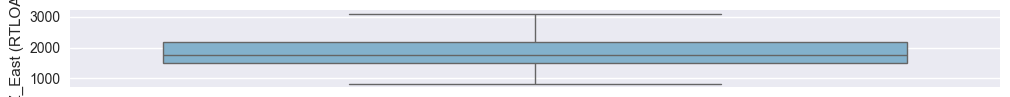

Distribution      min     mean  median      max     std  \
WZ_FarWest (RTLOAD)     pearson3  3605.08  4549.59  4473.8  5519.61  370.86   

                           var  kurt  skew 2.5th_ptile 97.5th_ptile  
WZ_FarWest (RTLOAD)  137538.52 -0.69  0.39     3965.64      5289.73

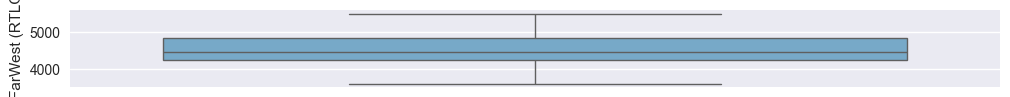

Distribution     min     mean   median      max     std  \
WZ_North (RTLOAD)     pearson3  707.09  1309.81  1238.47  2216.77  316.38   

                         var  kurt  skew 2.5th_ptile 97.5th_ptile  
WZ_North (RTLOAD)  100097.81 -0.23  0.75      859.35      2022.72

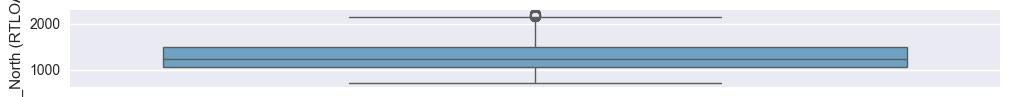

Distribution      min      mean    median       max  \
WZ_NorthCentral (RTLOAD)        gamma  8067.61  15224.08  14211.76  27389.92   

                              std          var  kurt  skew 2.5th_ptile  \
WZ_NorthCentral (RTLOAD)  4302.81  18514199.38 -0.31  0.72     9028.17   

                         97.5th_ptile  
WZ_NorthCentral (RTLOAD)     24955.53

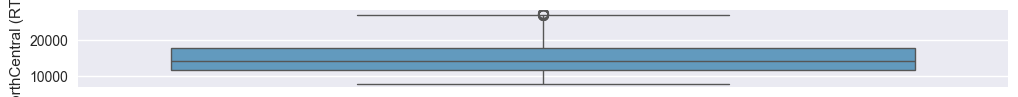

Distribution      min     mean  median      max  \
WZ_SouthCentral (RTLOAD)     pearson3  4832.03  8320.56  7807.2  13931.8   

                              std         var  kurt  skew 2.5th_ptile  \
WZ_SouthCentral (RTLOAD)  2174.81  4729783.95 -0.52  0.67     5198.84   

                         97.5th_ptile  
WZ_SouthCentral (RTLOAD)     13036.52

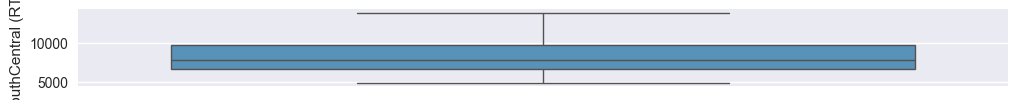

Distribution      min    mean   median      max     std  \
WZ_Southern (RTLOAD)       triang  2327.06  3982.3  3779.76  6296.45  933.82   

                            var kurt  skew 2.5th_ptile 97.5th_ptile  
WZ_Southern (RTLOAD)  872010.61 -0.7  0.53     2575.06      5900.69

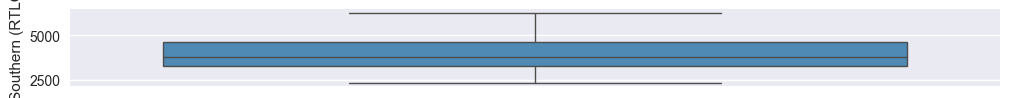

Distribution     min     mean   median      max     std  \
WZ_West (RTLOAD)        gamma  707.45  1534.02  1471.34  2526.78  322.95   

                        var  kurt  skew 2.5th_ptile 97.5th_ptile  
WZ_West (RTLOAD)  104299.78 -0.46  0.53     1037.75      2216.63

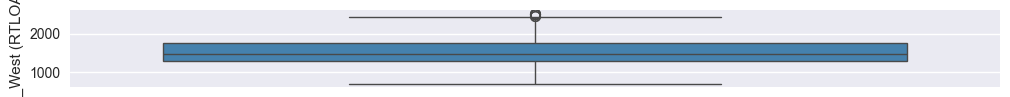

Distribution     min      mean   median  \
WZ_Coast (BIDCLOSE_LOAD_FORECAST)     pearson3  8770.7  13543.25  12710.3   

                                       max      std         var  kurt  skew  \
WZ_Coast (BIDCLOSE_LOAD_FORECAST)  21272.4  2879.09  8289177.42 -0.32  0.79   

                                  2.5th_ptile 97.5th_ptile  
WZ_Coast (BIDCLOSE_LOAD_FORECAST)     9457.83     19973.35

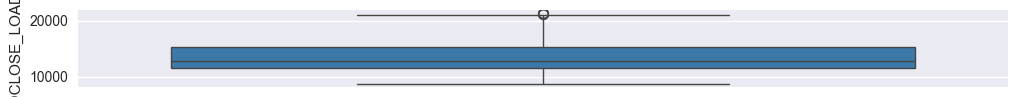

Distribution       min      mean    median  \
WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)        gamma  30359.95  50131.07  47299.57   

                                        max      std           var kurt  skew  \
WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)  81430.82  11614.8  134903675.77 -0.3  0.75   

                                  2.5th_ptile 97.5th_ptile  
WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)     33373.9     76002.09

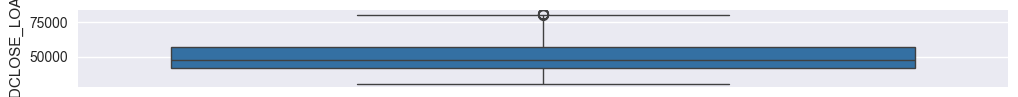

Distribution      min     mean   median  \
WZ_East (BIDCLOSE_LOAD_FORECAST)        gamma  1035.16  1904.29  1795.28   

                                      max     std        var  kurt skew  \
WZ_East (BIDCLOSE_LOAD_FORECAST)  3586.48  481.41  231755.17 -0.25  0.7   

                                 2.5th_ptile 97.5th_ptile  
WZ_East (BIDCLOSE_LOAD_FORECAST)     1186.31      2967.91

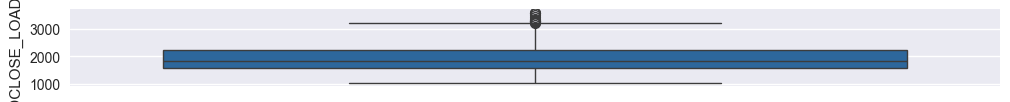

Distribution     min     mean   median  \
WZ_FarWest (BIDCLOSE_LOAD_FORECAST)        gamma  3117.0  4492.57  4406.02   

                                         max     std        var  kurt  skew  \
WZ_FarWest (BIDCLOSE_LOAD_FORECAST)  5505.31  384.62  147933.09 -0.32  0.52   

                                    2.5th_ptile 97.5th_ptile  
WZ_FarWest (BIDCLOSE_LOAD_FORECAST)     3915.42      5331.56

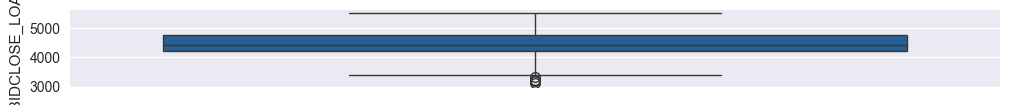

Distribution     min     mean   median  \
WZ_North (BIDCLOSE_LOAD_FORECAST)      lognorm  354.99  1304.42  1239.11   

                                       max     std        var  kurt  skew  \
WZ_North (BIDCLOSE_LOAD_FORECAST)  2737.02  346.31  119931.83  0.38  0.69   

                                  2.5th_ptile 97.5th_ptile  
WZ_North (BIDCLOSE_LOAD_FORECAST)      788.55      2046.86

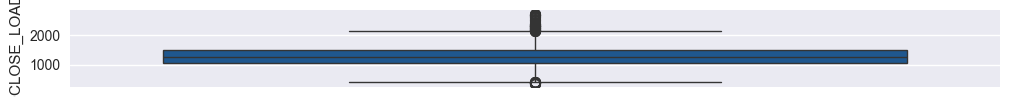

Distribution      min      mean  \
WZ_NorthCentral (BIDCLOSE_LOAD_FORECAST)        gamma  7821.29  15235.43   

                                           median      max     std  \
WZ_NorthCentral (BIDCLOSE_LOAD_FORECAST)  14118.1  28463.2  4486.3   

                                                  var  kurt  skew 2.5th_ptile  \
WZ_NorthCentral (BIDCLOSE_LOAD_FORECAST)  20126885.84 -0.26  0.76     8848.18   

                                         97.5th_ptile  
WZ_NorthCentral (BIDCLOSE_LOAD_FORECAST)     25330.64

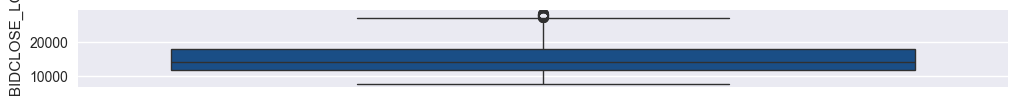

Distribution      min     mean  \
WZ_SouthCentral (BIDCLOSE_LOAD_FORECAST)     pearson3  4220.47  8201.05   

                                           median      max      std  \
WZ_SouthCentral (BIDCLOSE_LOAD_FORECAST)  7680.79  14566.1  2248.75   

                                                 var  kurt  skew 2.5th_ptile  \
WZ_SouthCentral (BIDCLOSE_LOAD_FORECAST)  5056859.18 -0.42  0.68     4927.59   

                                         97.5th_ptile  
WZ_SouthCentral (BIDCLOSE_LOAD_FORECAST)     13117.73

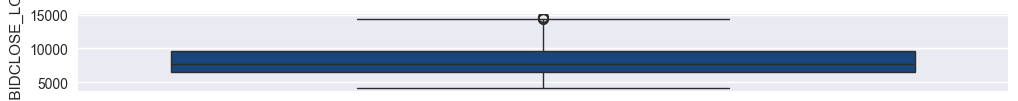

Distribution      min     mean   median  \
WZ_Southern (BIDCLOSE_LOAD_FORECAST)       triang  2223.62  3929.68  3723.27   

                                          max     std        var  kurt  skew  \
WZ_Southern (BIDCLOSE_LOAD_FORECAST)  6757.03  950.24  902954.33 -0.65  0.54   

                                     2.5th_ptile 97.5th_ptile  
WZ_Southern (BIDCLOSE_LOAD_FORECAST)     2491.79      5894.74

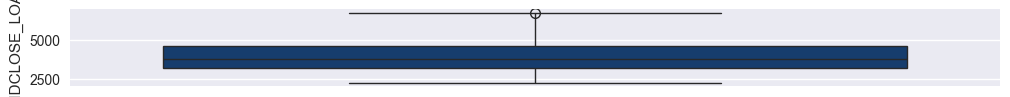

Distribution     min     mean  median  \
WZ_West (BIDCLOSE_LOAD_FORECAST)  weibull_min  891.37  1520.37  1447.0   

                                      max     std        var  kurt  skew  \
WZ_West (BIDCLOSE_LOAD_FORECAST)  2654.53  335.23  112378.75 -0.46  0.61   

                                 2.5th_ptile 97.5th_ptile  
WZ_West (BIDCLOSE_LOAD_FORECAST)     1032.94      2209.25

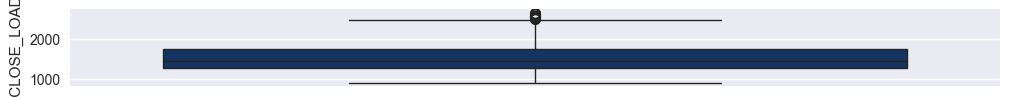

Distribution  min  mean median   max   std   var  kurt  skew  \
Katy (GASPRICE)         beta  3.4  6.03    6.2  9.33  1.62  2.63 -1.34  0.04   

                2.5th_ptile 97.5th_ptile  
Katy (GASPRICE)         3.6         8.75

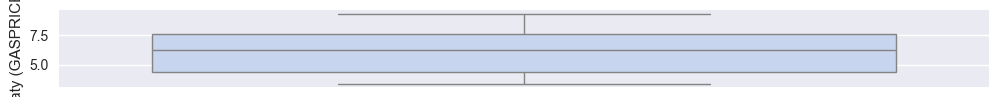

Distribution   min  mean median   max   std   var  kurt  \
Henry (GASPRICE)         beta  3.58  6.31    6.4  9.45  1.64  2.69 -1.32   

                  skew 2.5th_ptile 97.5th_ptile  
Henry (GASPRICE)  0.08        3.78          9.0

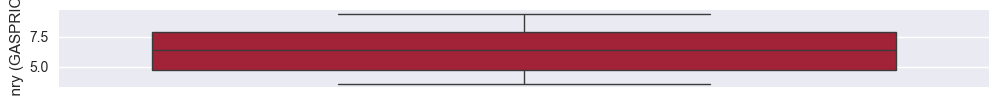

Distribution     min      mean  median  \
ERCOT (TOTAL_RESOURCE_CAP_OUT)     invgauss  3697.0  12264.41  9319.0   

                                    max      std          var  kurt  skew  \
ERCOT (TOTAL_RESOURCE_CAP_OUT)  25631.0  6937.88  48134173.04 -1.15  0.63   

                               2.5th_ptile 97.5th_ptile  
ERCOT (TOTAL_RESOURCE_CAP_OUT)      4393.0      25037.0

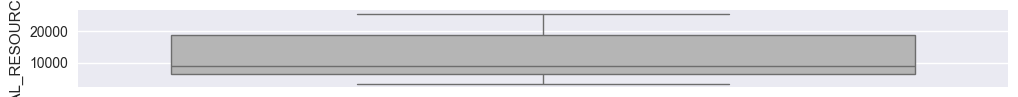

Distribution   min   mean median      max    std       var  \
HB_NORTH (RTLMP)      lognorm -29.7  65.94   43.5  5365.85  202.4  40965.69   

                    kurt  skew 2.5th_ptile 97.5th_ptile  
HB_NORTH (RTLMP)  360.44  17.2        4.58       195.13

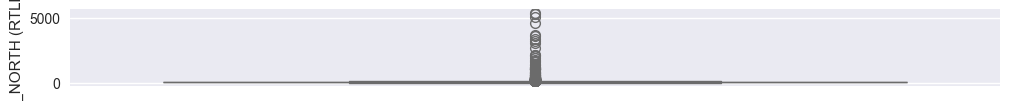

Distribution   min     mean  median      max  \
ERCOT (GENERATION_SOLAR_RT)        gamma -0.64  2865.48  409.17  9702.52   

                                 std          var kurt  skew 2.5th_ptile  \
ERCOT (GENERATION_SOLAR_RT)  3410.83  11633792.06 -1.2  0.67        0.03   

                            97.5th_ptile  
ERCOT (GENERATION_SOLAR_RT)      9178.74

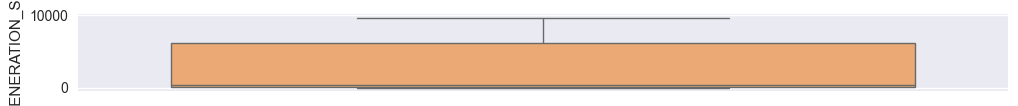

Distribution  min     mean median      max  \
ERCOT (SOLAR_STPPF_BIDCLOSE)          NaN  0.0  3266.95  430.7  10020.3   

                                  std          var  kurt  skew 2.5th_ptile  \
ERCOT (SOLAR_STPPF_BIDCLOSE)  3790.18  14365445.62 -1.47  0.53         0.0   

                             97.5th_ptile  
ERCOT (SOLAR_STPPF_BIDCLOSE)      9625.81

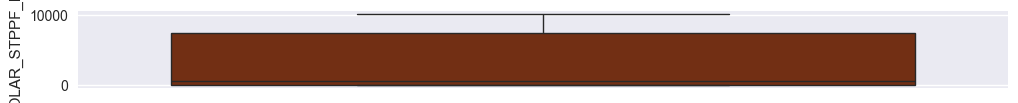

Distribution  min     mean   median      max      std  \
GR_COASTAL (WINDDATA)         beta  0.0  1800.16  1747.19  3948.05  1142.21   

                              var kurt  skew 2.5th_ptile 97.5th_ptile  
GR_COASTAL (WINDDATA)  1304652.98 -1.3  0.07       37.29      3662.56

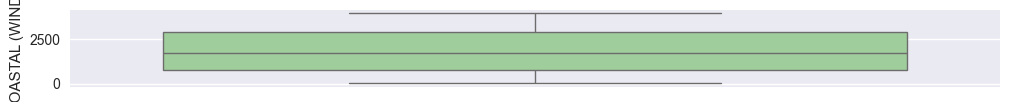

Distribution    min      mean    median       max  \
GR_ERCOT (WINDDATA)         beta  307.6  13577.02  13898.39  26859.39   

                         std          var  kurt  skew 2.5th_ptile 97.5th_ptile  
GR_ERCOT (WINDDATA)  6440.08  41474663.09 -1.09 -0.13     1958.94     23956.94

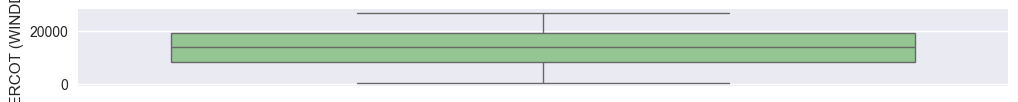

Distribution   min     mean  median      max     std  \
GR_NORTH (WINDDATA)         beta -0.69  1012.76  983.42  2213.84  639.48   

                           var kurt  skew 2.5th_ptile 97.5th_ptile  
GR_NORTH (WINDDATA)  408939.65 -1.3  0.07       39.57       2063.6

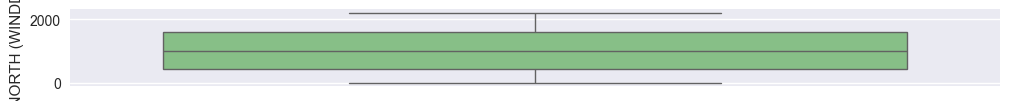

Distribution   min     mean   median      max  \
GR_PANHANDLE (WINDDATA)      uniform  0.27  2004.37  2122.65  4034.66   

                             std         var  kurt  skew 2.5th_ptile  \
GR_PANHANDLE (WINDDATA)  1132.69  1282989.28 -1.24 -0.17       89.05   

                        97.5th_ptile  
GR_PANHANDLE (WINDDATA)       3730.5

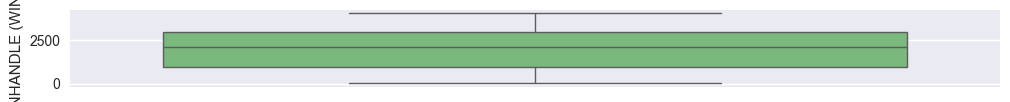

Distribution   min     mean   median      max     std  \
GR_SOUTH (WINDDATA)         beta -0.78  1655.79  1722.51  3345.82  887.71   

                           var  kurt  skew 2.5th_ptile 97.5th_ptile  
GR_SOUTH (WINDDATA)  788032.41 -1.11 -0.11      110.09      3130.14

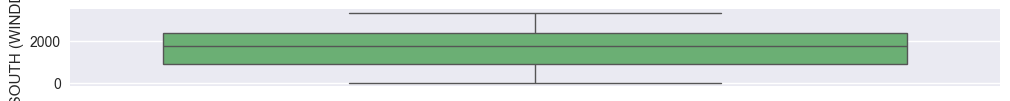

Distribution   min     mean   median       max      std  \
GR_WEST (WINDDATA)      uniform  1.13  7103.94  7339.88  14504.82  4021.95   

                            var  kurt  skew 2.5th_ptile 97.5th_ptile  
GR_WEST (WINDDATA)  16176065.12 -1.26 -0.11      406.51     13340.74

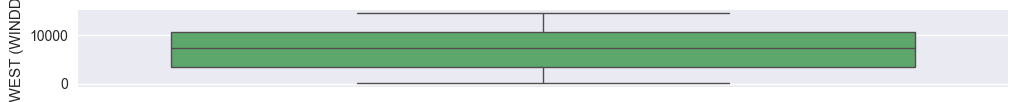

Distribution    min      mean   median      max  \
ERCOT (WIND_STWPF_BIDCLOSE)         beta  429.0  14229.14  13964.8  30451.8   

                                 std         var  kurt  skew 2.5th_ptile  \
ERCOT (WIND_STWPF_BIDCLOSE)  7157.91  51235706.4 -0.95  0.16     2265.01   

                            97.5th_ptile  
ERCOT (WIND_STWPF_BIDCLOSE)     27624.59

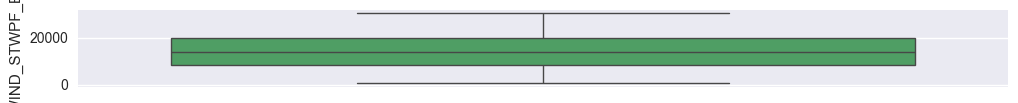

Distribution  min     mean  median     max  \
GR_COASTAL (WIND_STWPF_BIDCLOSE)         beta  5.6  1930.38  1707.6  4708.3   

                                      std         var  kurt  skew 2.5th_ptile  \
GR_COASTAL (WIND_STWPF_BIDCLOSE)  1293.64  1673517.31 -1.08  0.33       76.09   

                                 97.5th_ptile  
GR_COASTAL (WIND_STWPF_BIDCLOSE)      4338.48

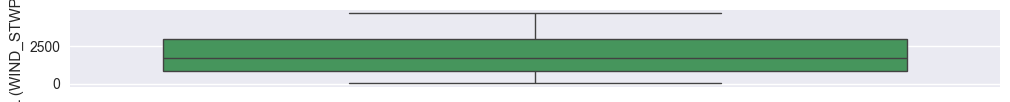

Distribution    min      mean   median  \
GR_ERCOT (WIND_STWPF_BIDCLOSE)         beta  429.0  14229.12  13964.8   

                                    max      std          var  kurt  skew  \
GR_ERCOT (WIND_STWPF_BIDCLOSE)  30451.8  7157.89  51235425.35 -0.95  0.16   

                               2.5th_ptile 97.5th_ptile  
GR_ERCOT (WIND_STWPF_BIDCLOSE)     2265.01     27624.52

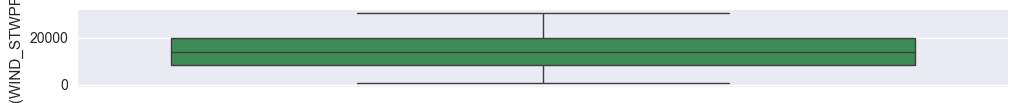

Distribution  min     mean median     max  \
GR_NORTH (WIND_STWPF_BIDCLOSE)         beta  0.2  1020.03  968.5  2295.2   

                                   std        var  kurt  skew 2.5th_ptile  \
GR_NORTH (WIND_STWPF_BIDCLOSE)  647.32  419020.23 -1.27  0.17        58.2   

                               97.5th_ptile  
GR_NORTH (WIND_STWPF_BIDCLOSE)      2119.47

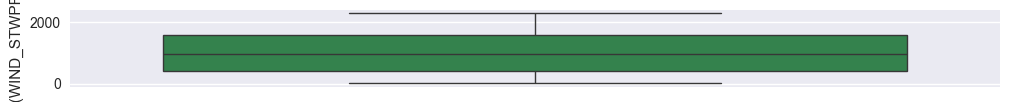

Distribution  min     mean  median     max  \
GR_PANHANDLE (WIND_STWPF_BIDCLOSE)      uniform  8.4  2057.01  2127.2  4083.0   

                                        std         var  kurt  skew  \
GR_PANHANDLE (WIND_STWPF_BIDCLOSE)  1148.77  1319683.83 -1.22 -0.06   

                                   2.5th_ptile 97.5th_ptile  
GR_PANHANDLE (WIND_STWPF_BIDCLOSE)      157.83      3870.07

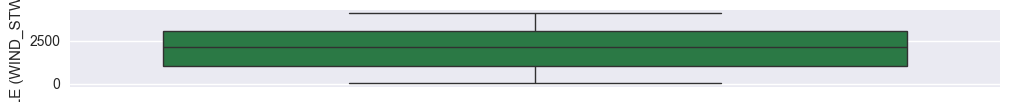

Distribution   min     mean  median     max  \
GR_SOUTH (WIND_STWPF_BIDCLOSE)         beta  15.7  1759.44  1715.4  3844.4   

                                   std        var  kurt  skew 2.5th_ptile  \
GR_SOUTH (WIND_STWPF_BIDCLOSE)  977.75  955987.58 -1.02  0.15      184.98   

                               97.5th_ptile  
GR_SOUTH (WIND_STWPF_BIDCLOSE)      3566.67

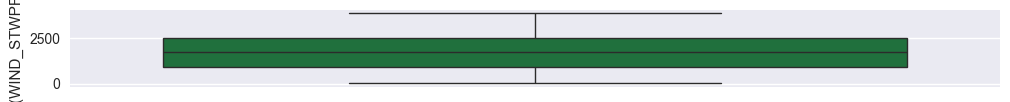

Distribution   min     mean  median      max  \
GR_WEST (WIND_STWPF_BIDCLOSE)         beta  83.2  7462.26  7321.8  16371.4   

                                   std          var  kurt  skew 2.5th_ptile  \
GR_WEST (WIND_STWPF_BIDCLOSE)  4372.55  19119193.23 -1.12  0.12      554.09   

                              97.5th_ptile  
GR_WEST (WIND_STWPF_BIDCLOSE)      15285.2

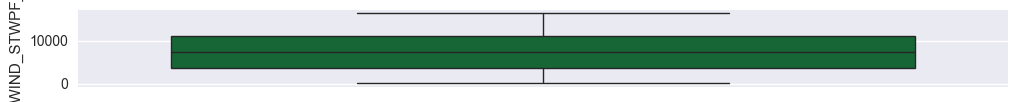

Distribution  min     mean  median  \
NORTH (ERCOT) (WIND_STWPF_BIDCLOSE)         beta  0.2  1075.51  1039.4   

                                        max     std        var  kurt  skew  \
NORTH (ERCOT) (WIND_STWPF_BIDCLOSE)  2400.6  671.06  450323.83 -1.26  0.14   

                                    2.5th_ptile 97.5th_ptile  
NORTH (ERCOT) (WIND_STWPF_BIDCLOSE)        62.3      2233.29

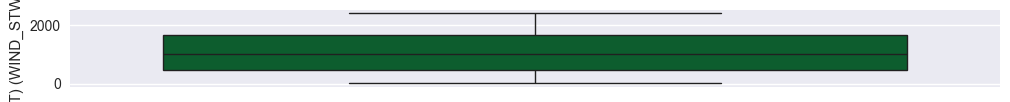

Distribution   min     mean  median  \
SOUTH_HOUSTON (WIND_STWPF_BIDCLOSE)         beta  47.2  3645.02  3396.4   

                                        max      std        var  kurt  skew  \
SOUTH_HOUSTON (WIND_STWPF_BIDCLOSE)  8311.6  2072.11  4293626.5 -1.06  0.25   

                                    2.5th_ptile 97.5th_ptile  
SOUTH_HOUSTON (WIND_STWPF_BIDCLOSE)      452.66      7482.43

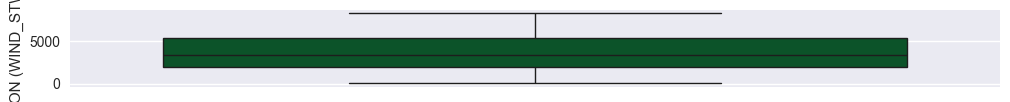

Distribution    min     mean  median  \
WEST (ERCOT) (WIND_STWPF_BIDCLOSE)         beta  190.0  9508.61  9366.3   

                                        max      std          var  kurt  skew  \
WEST (ERCOT) (WIND_STWPF_BIDCLOSE)  20413.1  5308.23  28177356.08 -1.09  0.12   

                                   2.5th_ptile 97.5th_ptile  
WEST (ERCOT) (WIND_STWPF_BIDCLOSE)       965.1     18957.86

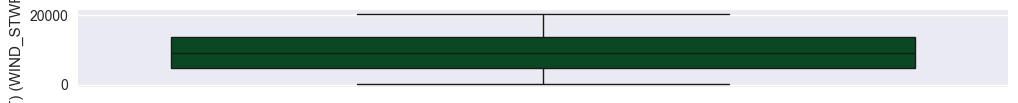

Distribution    min      mean   median  \
WEST_NORTH (WIND_STWPF_BIDCLOSE)         beta  292.2  10584.12  10359.0   

                                      max      std          var  kurt  skew  \
WEST_NORTH (WIND_STWPF_BIDCLOSE)  22691.0  5906.54  34887182.98 -1.11  0.12   

                                 2.5th_ptile 97.5th_ptile  
WEST_NORTH (WIND_STWPF_BIDCLOSE)     1135.96     21057.06

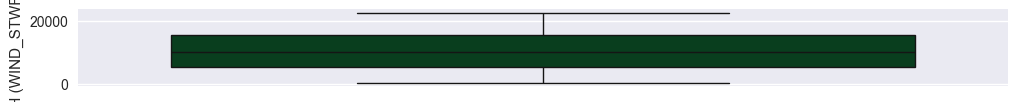

In [41]:
print('Descriptive Statistics, Moments, & Boxplots of all Features')
for col in df_features.index:
#     print(col)
    plt.figure(figsize=(12,1))
    sns.boxplot(df[col], color=colors_features[col])
    display(df_features.loc[col, cols_distribution_stats].to_frame().T.round(2))
    plt.show()


In [42]:
ax_.tick_params(axis='both', left=False, top=False, right=False, bottom=False,
                labelleft=False, labeltop=False, labelright=False, labelbottom=False)

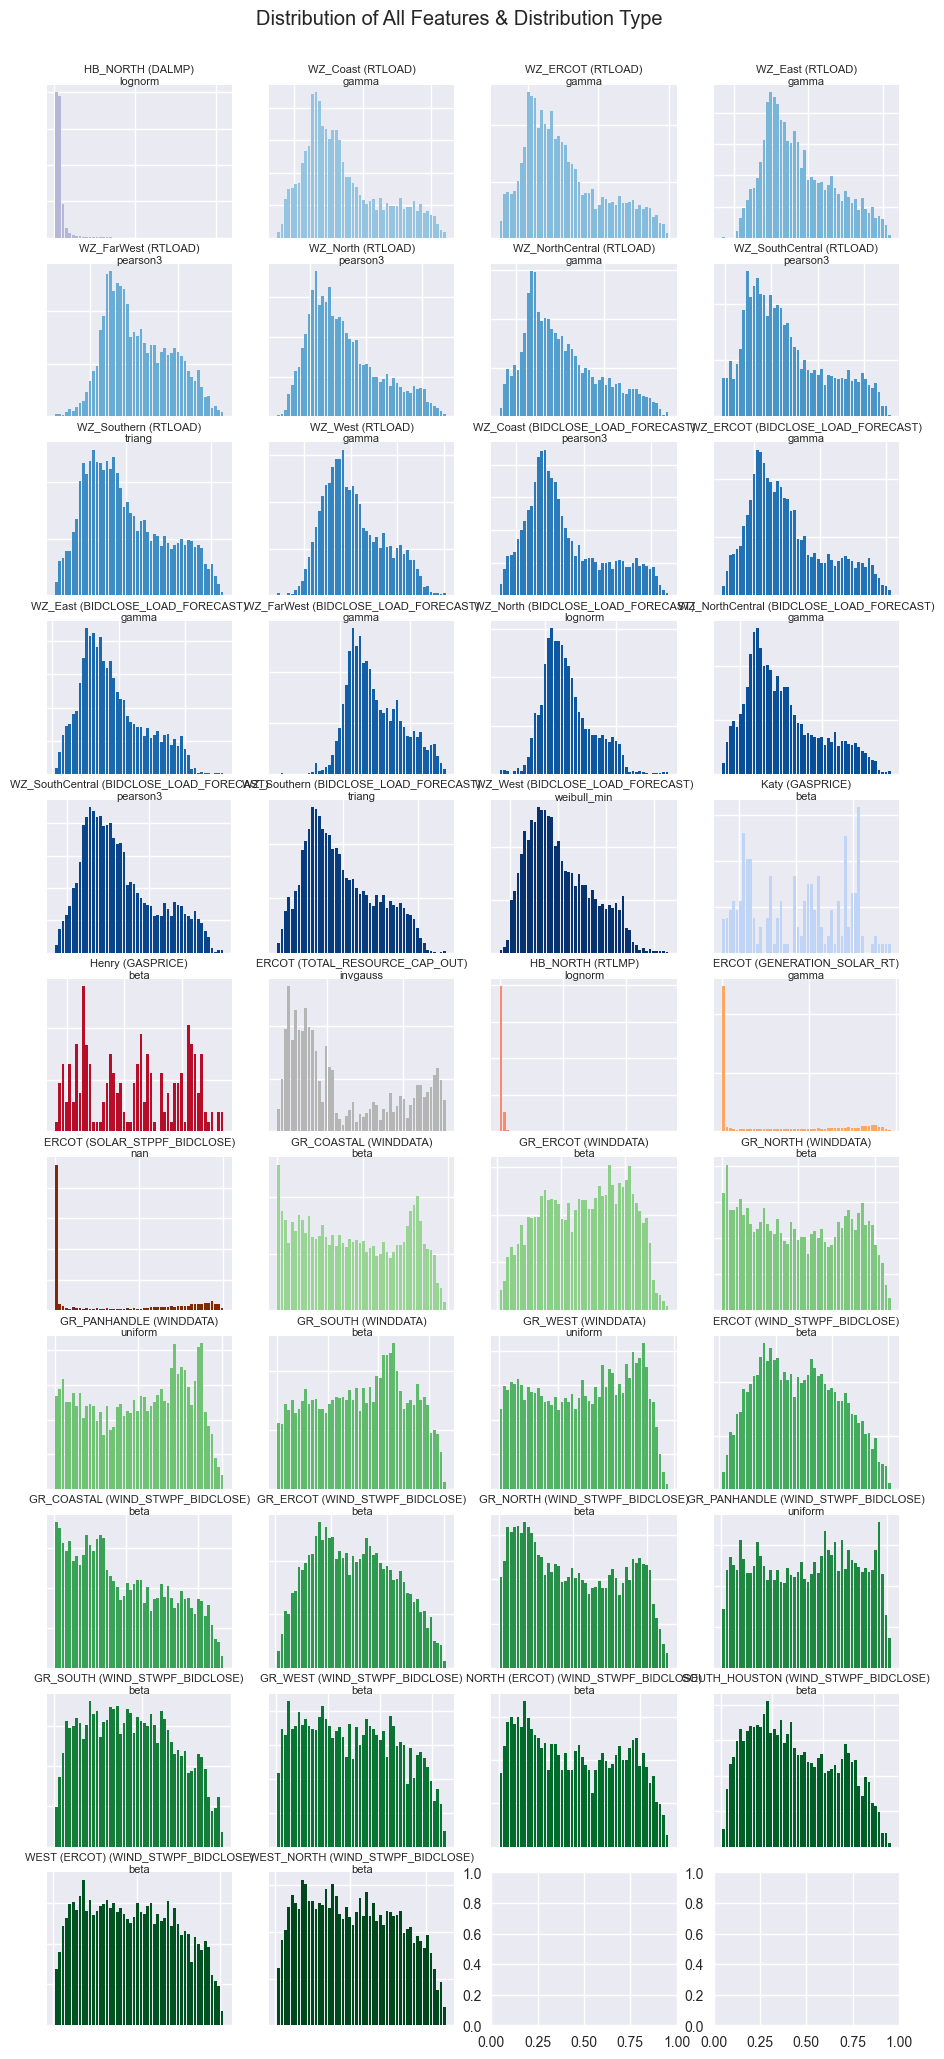

In [43]:
# print('Descriptive Statistics, Moments, & Boxplots of all Features')
n_features_ = df_features.shape[0]
# Calculate the number of rows and columns
n_cols_ = 4
n_rows_ = int(np.ceil(n_features_ / n_cols_))
fig, ax = plt.subplots(n_rows_, n_cols_, gridspec_kw={'hspace': 0.17}, figsize=[11, n_features_*0.6])
for col_, ax_ in zip(df_features.index, ax.flatten()):
    ax_.hist(df[col_], color=colors_features[col_], density=True, bins=50, rwidth=0.8)
    ax_.set_title(f'{col_}\n{feature_distribution_type[col_]}', fontsize=8, y=0.95)
#     no axis ticks or ticklabels
    ax_.tick_params(axis='both', left=False, top=False, right=False, bottom=False,
                labelleft=False, labeltop=False, labelright=False, labelbottom=False)
fig.suptitle('Distribution of All Features & Distribution Type', y=0.91)
plt.show()


## Add Features
Calculate additional features using the source columns.  Only use features that will be available during the Forecast period as defined in 'cols_valid_in_forecast'.   Ideally, thousands of features could be calculated and the most significant features would be selected and others discarded.  In the following steps 2 sets of basic rolling statistics will be calculated for each feature.  

Features will be calculated for all time intervals including forecast period.  Features calculated in forecast period may be needed for final forecasting exercise.  

By definition, rolling indicators/calculations are lagged.  Additional NaN values will appear in initial 'warm-up' records as well as some records with NaN values.    

Visual analysis and conventional wisdom imply that 24-hour and 7-day (168-hour) periods have repetitive cyclical behavior.  

Output dataframes will be saved as
* "df_features_rolling_<<period1>>"
* "df_features_rolling_<<period2>>"

__Future Improvements:__
1. Additional Feature types:
    * Stochastic/minimal lag features
    * 1st & 2nd differences of features
    * Additional source data to allow for additional feature calculation (ie., weather, industrial/macro-economic indicators, etc.)
2. Explore interaction between features:
    * differences between values within a given feature & differences between same values across different features
    * Use principal components analysis or similar to identify meaningful features and attempt to develop additional features as the combination of other significant features.

### Define calculations for new features
In an operational script these sets of calculations would best be stored in a class.

#### Identify Cyclical Periods 
Identify apparent short-term (< 1 week) cyclicality/seasonality in the time-series. See notebook "3 - Stationarity and Seasonality" for more details.  

In [45]:
periodic_spectral_density(df[cols_target[0]]).sample(3)

Power spectral density
H                           
3.0             1.003245e+05
3.0             8.683028e+05
91.0            1.035302e+08

#### Which periods are most significant in all target features?
In order to limit proliferation of features it is necessary to use a limited number of periods

In [46]:
features_periodicity = {col_ : periodicity_hourly(df[col_].dropna(), n=40) for
                        col_ in cols_target}
# collect values from features_periodicity, combine, count, and identify most frequent periods
periods_ranked = pd.Series([item for sublist in [l for l in features_periodicity.values()] for
                           item in sublist]).value_counts()
periods_target_features = list(map(int, periods_ranked.index))[:5]
display(periods_ranked.head(4))
print(f'The most common cyclical periods found in {", ".join(cols_target)} '
          f'are: {periods_target_features} hours')

24.0    16
12.0    14
25.0     6
23.0     4
dtype: int64

The most common cyclical periods found in HB_NORTH (DALMP), HB_NORTH (RTLMP) are: [24, 12, 25, 23, 30] hours


#### Define array of calculations and Rolling 'periods' to calculate statistics

In [128]:
n_periods_rolling = 2
# collection of functions used to generate statistical calculations
stats_rolling_ = stats_ + [slope, intercept, p_value]
# stats_rolling_ = stats_ + [slope_intercept_p_value_linear_ts]
periods = list(map(int, periods_target_features[:n_periods_rolling]))
rolling_dfs = {f"df_features_rolling_{period_}": pd.DataFrame() for period_ in periods}

#### Calculate Rolling Features
This is a large set of calculations and will require time to calculate.  As feature set grows, more performant file formats should be considered (i.e., 'parquet', 'hdf5', etc.)

In [129]:
%%time
for period_, df_name_ in zip(periods, rolling_dfs.keys()):
    print(period_)
#     calculate only on features known to be available during forecast
    temp = df[cols_valid_in_forecast].rolling(period_).agg(stats_rolling_)
#     convert multi-index columns to single column index with joined names
    cols_single_index = temp.columns.map('_'.join) 
    cols_single_index = [f'{c}_{period_}' for c in cols_single_index]
    temp = temp.droplevel(0, axis=1)
    temp.columns = cols_single_index
    rolling_dfs[df_name_] = temp.copy()

24
12
CPU times: total: 4min 44s
Wall time: 4min 44s


#### save rolling features dfs to disk as csv's - OPTIONAL

In [ ]:
# for key in rolling_dfs:
#     out_file_ = data_dir / (key.replace('df_', '') + '.csv')
#     print(out_file_)
#     rolling_dfs[key].to_csv(out_file_)

#### Create df_rolling to hold results of rolling_dfs dictionary

In [130]:
df_rolling = pd.concat(rolling_dfs, axis=1).droplevel(0, axis=1)
df_rolling.head()

WZ_Coast (BIDCLOSE_LOAD_FORECAST)_min_24  \
DATETIME                                                              
2022-01-01 07:00:00+00:00                                       NaN   
2022-01-01 08:00:00+00:00                                       NaN   
2022-01-01 09:00:00+00:00                                       NaN   
2022-01-01 10:00:00+00:00                                       NaN   
2022-01-01 11:00:00+00:00                                       NaN   

                           WZ_Coast (BIDCLOSE_LOAD_FORECAST)_mean_24  \
DATETIME                                                               
2022-01-01 07:00:00+00:00                                        NaN   
2022-01-01 08:00:00+00:00                                        NaN   
2022-01-01 09:00:00+00:00                                        NaN   
2022-01-01 10:00:00+00:00                                        NaN   
2022-01-01 11:00:00+00:00                                        NaN   

                           WZ_Coast (BIDCLOSE_LOAD_FORECAST)_median_24  \
DATETIME                                                                 
2022-01-01 07:00:00+00:00                                          NaN   
2022-01-01 08:00:00+00:00                                          NaN   
2022-01-01 09:00:00+00:00                                          NaN   
2022-01-01 10:00:00+00:00                                          NaN   
2022-01-01 11:00:00+00:00                                          NaN   

                           WZ_Coast (BIDCLOSE_LOAD_FORECAST)_max_24  \
DATETIME                                                              
2022-01-01 07:00:00+00:00                                       NaN   
2022-01-01 08:00:00+00:00                                       NaN   
2022-01-01 09:00:00+00:00                                       NaN   
2022-01-01 10:00:00+00:00                                       NaN   
2022-01-01 11:00:00+00:00                                       NaN   

                           WZ_Coast (BIDCLOSE_LOAD_FORECAST)_std_24  \
DATETIME                                                              
2022-01-01 07:00:00+00:00                                       NaN   
2022-01-01 08:00:00+00:00                                       NaN   
2022-01-01 09:00:00+00:00                                       NaN   
2022-01-01 10:00:00+00:00                                       NaN   
2022-01-01 11:00:00+00:00                                       NaN   

                           WZ_Coast (BIDCLOSE_LOAD_FORECAST)_var_24  \
DATETIME                                                              
2022-01-01 07:00:00+00:00                                       NaN   
2022-01-01 08:00:00+00:00                                       NaN   
2022-01-01 09:00:00+00:00                                       NaN   
2022-01-01 10:00:00+00:00                                       NaN   
2022-01-01 11:00:00+00:00                                       NaN   

                           WZ_Coast (BIDCLOSE_LOAD_FORECAST)_kurt_24  \
DATETIME                                                               
2022-01-01 07:00:00+00:00                                        NaN   
2022-01-01 08:00:00+00:00                                        NaN   
2022-01-01 09:00:00+00:00                                        NaN   
2022-01-01 10:00:00+00:00                                        NaN   
2022-01-01 11:00:00+00:00                                        NaN   

                           WZ_Coast (BIDCLOSE_LOAD_FORECAST)_skew_24  \
DATETIME                                                               
2022-01-01 07:00:00+00:00                                        NaN   
2022-01-01 08:00:00+00:00                                        NaN   
2022-01-01 09:00:00+00:00                                        NaN   
2022-01-01 10:00:00+00:00                                        NaN   
2022-01-01 11:00:00+00:00                                        NaN   

 

### Create Date Features - df_date
Some Date-related columns may already be present.  For subsequent modeling steps all data must be numeric.   Add numeric and additional date-related features

In [131]:
df_date = pd.DataFrame(index=df.index)

df_date['month_number'] = df_date.index.month
df_date['day_of_week'] = df_date.index.day_of_week
df_date['week_of_year'] = df_date.index.weekofyear
df_date['day_of_year'] = df_date.index.day_of_year

#### Identify Federal Holidays

In [132]:
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df_date.index.date[0], end=df_date.index.date[-1])
holiday_bool = [1 if pd.Timestamp(x) in holidays else 0 for x in df_date.index.date]
df_date['is_holiday'] = holiday_bool
cols_date = ['month_number','day_of_week','week_of_year', 'day_of_year', 'is_holiday']

In [133]:
assert df_date['is_holiday'].value_counts().loc[1]/24 == len(holidays)
df_date[cols_date].sample(5).sort_index()

month_number  day_of_week  week_of_year  \
DATETIME                                                             
2022-02-07 06:00:00+00:00             2            0             6   
2022-06-05 11:00:00+00:00             6            6            22   
2022-06-27 19:00:00+00:00             6            0            26   
2022-07-03 04:00:00+00:00             7            6            26   
2022-07-14 15:00:00+00:00             7            3            28   

                           day_of_year  is_holiday  
DATETIME                                            
2022-02-07 06:00:00+00:00           38           0  
2022-06-05 11:00:00+00:00          156           0  
2022-06-27 19:00:00+00:00          178           0  
2022-07-03 04:00:00+00:00          184           0  
2022-07-14 15:00:00+00:00          195           0

## Principal Components Analysis (PCA)
A significant quantity of features have been generated by this point.  Some features will be more useful than others in terms of their ability to forecast the target features.  Use PCA to reduce the total feature collection by keeping only variables that have a signficant ability to explain the variance of the dataset.

#### Collect various dfs with features in to df_features_pre_pca

In [134]:
# exclude target columns as well as non-numeric data types
dfs_ts_features = [df[cols_valid_in_forecast]\
                       .select_dtypes(exclude=[object, bool]),
#                   df_lagged,
                  df_rolling,
                  df_date]

In [135]:
# use all available data, regardless of forecast status (beware look ahead bias)
# df_features_pre_pca = pd.concat(dfs_ts_features, axis=1).loc[out_forecast]
df_features_pre_pca = pd.concat(dfs_ts_features, axis=1)
df_features_pre_pca.head()

WZ_Coast (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                       
2022-01-01 07:00:00+00:00                         10307.0996   
2022-01-01 08:00:00+00:00                         10300.2002   
2022-01-01 09:00:00+00:00                         10313.0000   
2022-01-01 10:00:00+00:00                         10253.7998   
2022-01-01 11:00:00+00:00                         10206.0996   

                           WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                       
2022-01-01 07:00:00+00:00                         37308.3496   
2022-01-01 08:00:00+00:00                         36984.0036   
2022-01-01 09:00:00+00:00                         36764.8666   
2022-01-01 10:00:00+00:00                         36163.0723   
2022-01-01 11:00:00+00:00                         35615.0476   

                           WZ_East (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                      
2022-01-01 07:00:00+00:00                           1282.52   
2022-01-01 08:00:00+00:00                           1260.64   
2022-01-01 09:00:00+00:00                           1245.84   
2022-01-01 10:00:00+00:00                           1214.41   
2022-01-01 11:00:00+00:00                           1185.40   

                           WZ_FarWest (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                         
2022-01-01 07:00:00+00:00                            3657.7300   
2022-01-01 08:00:00+00:00                            3660.2400   
2022-01-01 09:00:00+00:00                            3668.4399   
2022-01-01 10:00:00+00:00                            3673.6001   
2022-01-01 11:00:00+00:00                            3668.7000   

                           WZ_North (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                       
2022-01-01 07:00:00+00:00                            819.630   
2022-01-01 08:00:00+00:00                            759.254   
2022-01-01 09:00:00+00:00                            725.907   
2022-01-01 10:00:00+00:00                            720.712   
2022-01-01 11:00:00+00:00                            704.308   

                           WZ_NorthCentral (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                              
2022-01-01 07:00:00+00:00                                10433.5000   
2022-01-01 08:00:00+00:00                                10346.5996   
2022-01-01 09:00:00+00:00                                10346.5996   
2022-01-01 10:00:00+00:00                                10158.9004   
2022-01-01 11:00:00+00:00                                10016.0000   

                           WZ_SouthCentral (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                              
2022-01-01 07:00:00+00:00                                 6365.8901   
2022-01-01 08:00:00+00:00                                 6287.0098   
2022-01-01 09:00:00+00:00                                 6146.4502   
2022-01-01 10:00:00+00:00                                 5922.2500   
2022-01-01 11:00:00+00:00                                 5733.7900   

                           WZ_Southern (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                          
2022-01-01 07:00:00+00:00                             2852.1899   
2022-01-01 08:00:00+00:00                             2842.3000   
2022-01-01 09:00:00+00:00                             2785.6599   
2022-01-01 10:00:00+00:00                             2701.7300   
2022-01-01 11:00:00+00:00                             2646.4399   

                           WZ_West (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                      
2022-01-01 07:00:00+00:00                         1589.7900   
2022-01-01 08:00:00+00:00                         1527.7600   
2022-01-01 09:00:00+00:00                         1532.97

#### Drop all records with NaN values

In [136]:
# This will come at the loss of some valid data mixed with NaNs from rolling
# variables startup period
# don't accept a loss of more than 5% of records
nan_portion_max_pre_pca = 0.05
nan_fraction = df_features_pre_pca.isna().any(1).sum() / df_features_pre_pca.shape[0]
assert nan_fraction < nan_portion_max_pre_pca
df_features_pre_pca.dropna(how='any', axis=0, inplace=True)
# verify no gaps in datetime index
assert pd.Series(df_features_pre_pca.index).diff().nunique() == 1
df_features_pre_pca.tail(3)

WZ_Coast (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                       
2022-08-19 03:00:00+00:00                         16821.0996   
2022-08-19 04:00:00+00:00                         15956.9004   
2022-08-19 05:00:00+00:00                         15032.0000   

                           WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                       
2022-08-19 03:00:00+00:00                         62122.4999   
2022-08-19 04:00:00+00:00                         58237.7999   
2022-08-19 05:00:00+00:00                         54260.6896   

                           WZ_East (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                      
2022-08-19 03:00:00+00:00                           2269.74   
2022-08-19 04:00:00+00:00                           2105.77   
2022-08-19 05:00:00+00:00                           1934.14   

                           WZ_FarWest (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                         
2022-08-19 03:00:00+00:00                            5067.2598   
2022-08-19 04:00:00+00:00                            4939.5898   
2022-08-19 05:00:00+00:00                            4822.8301   

                           WZ_North (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                       
2022-08-19 03:00:00+00:00                          1553.4200   
2022-08-19 04:00:00+00:00                          1447.1500   
2022-08-19 05:00:00+00:00                          1342.9301   

                           WZ_NorthCentral (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                              
2022-08-19 03:00:00+00:00                                18971.3008   
2022-08-19 04:00:00+00:00                                17435.5000   
2022-08-19 05:00:00+00:00                                15946.5000   

                           WZ_SouthCentral (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                              
2022-08-19 03:00:00+00:00                                10973.2998   
2022-08-19 04:00:00+00:00                                10213.7998   
2022-08-19 05:00:00+00:00                                 9412.5195   

                           WZ_Southern (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                          
2022-08-19 03:00:00+00:00                             4858.8599   
2022-08-19 04:00:00+00:00                             4578.1299   
2022-08-19 05:00:00+00:00                             4288.1099   

                           WZ_West (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                      
2022-08-19 03:00:00+00:00                           1607.52   
2022-08-19 04:00:00+00:00                           1560.96   
2022-08-19 05:00:00+00:00                           1481.66   

                           ERCOT (TOTAL_RESOURCE_CAP_OUT)  \
DATETIME                                                    
2022-08-19 03:00:00+00:00                          3474.0   
2022-08-19 04:00:00+00:00                          3768.0   
2022-08-19 05:00:00+00:00                          3768.0   

                           ERCOT (SOLAR_STPPF_BIDCLOSE)  \
DATETIME                                                  
2022-08-19 03:00:00+00:00                           0.0   
2022-08-19 04:00:00+00:00                           0.0   
2022-08-19 05:00:00+00:00                           0.0   

                           ERCOT (WIND_STWPF_BIDCLOSE)  \
DATETIME                                                 
2022-08-19 03:00:00+00:00                       5848.0   
2022-08-19 04:00:00+00:00                       5827.4   
2022-08-19 05:00:00+00:00                       5527.3   

                           GR_COASTAL (WIND_STWPF_BIDCLOSE)  \
DATETIME                                                      
2022-08-19 03:00:00+00:00         

#### How Many Features are there?

In [137]:
n_features_ts_total = sum([x.columns.nunique() for x in dfs_ts_features])
print(f'There are {n_features_ts_total:,} Unique Features available '
      f'for {df_features_pre_pca.index.shape[0]:,} time intervals')

There are 511 Unique Features available for 5,496 time intervals


#### Perform Principal Component Analysis
Note this is for linear relationships.  Non-linear PCA is not performed here.
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [138]:
X = df_features_pre_pca.values # getting all values as a matrix of dataframe 
sc = StandardScaler() # initiate StandardScaler 
X_std = sc.fit_transform(X) # standardize the data - this

In [139]:
pca = PCA()
X_pca = pca.fit(X_std)

#### Visualize Explained Variance of each Feature

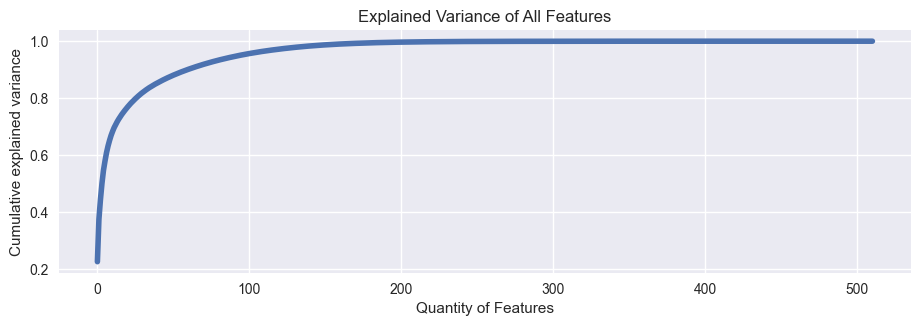

In [140]:
plt.figure(figsize = (11,3.15))
plt.plot(np.cumsum(X_pca.explained_variance_ratio_), lw=4)
plt.xlabel('Quantity of Features')
plt.ylabel('Cumulative explained variance');
plt.title('Explained Variance of All Features')
plt.show()

#### Store Explained Variance by Feature in df_pca
Use this df to identify significance by feature

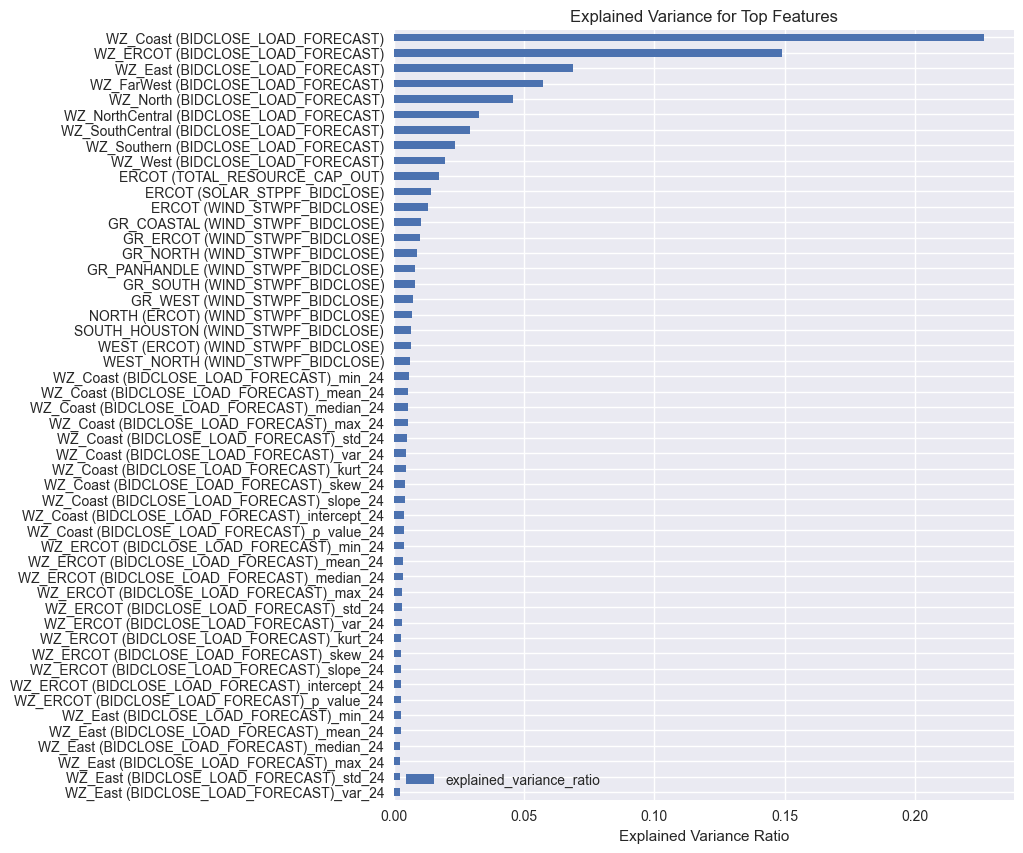

In [141]:
df_pca = pd.DataFrame(index=df_features_pre_pca.columns, 
                     data={'explained_variance_ratio': X_pca.explained_variance_ratio_})\
                        .sort_values('explained_variance_ratio', ascending=False)
# df_pca.head()

df_pca.head(50)[::-1].plot.barh(figsize=(8,10), title='Explained Variance for Top Features',
                               )
plt.xlabel('Explained Variance Ratio')
plt.show()

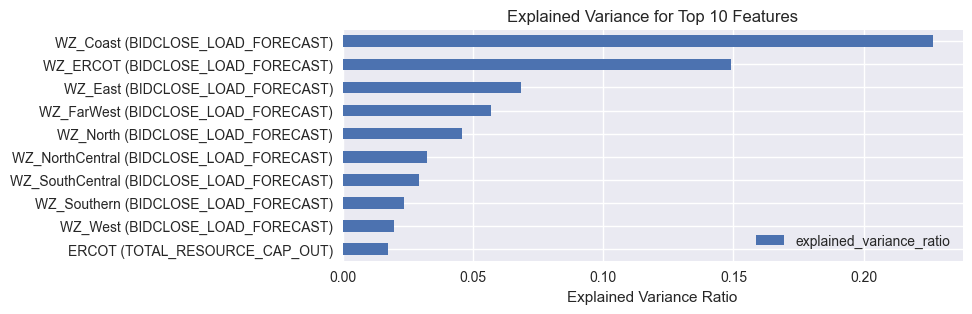

In [142]:
df_pca = pd.DataFrame(index=df_features_pre_pca.columns, 
                     data={'explained_variance_ratio': X_pca.explained_variance_ratio_})\
                        .sort_values('explained_variance_ratio', ascending=False)
df_pca.head(10)[::-1].plot.barh(figsize=(8,3), title='Explained Variance for Top 10 Features',
                               )
plt.xlabel('Explained Variance Ratio')
plt.show()

#### Select Features that account for min_var_explained Variance

In [143]:
# what is the minimum cumulative explained variance needed?  this is a question of accuracy
# (higher value) vs. speed and/or overfitting/robust performance (lower value).
min_var_explained = 0.90

In [144]:
df_pca['cumulative_explained_variance_ratio'] = df_pca['explained_variance_ratio'].cumsum()
df_pca.head(5)

explained_variance_ratio  \
WZ_Coast (BIDCLOSE_LOAD_FORECAST)                    0.226630   
WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)                    0.149038   
WZ_East (BIDCLOSE_LOAD_FORECAST)                     0.068581   
WZ_FarWest (BIDCLOSE_LOAD_FORECAST)                  0.057062   
WZ_North (BIDCLOSE_LOAD_FORECAST)                    0.045867   

                                     cumulative_explained_variance_ratio  
WZ_Coast (BIDCLOSE_LOAD_FORECAST)                               0.226630  
WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)                               0.375668  
WZ_East (BIDCLOSE_LOAD_FORECAST)                                0.444248  
WZ_FarWest (BIDCLOSE_LOAD_FORECAST)                             0.501311  
WZ_North (BIDCLOSE_LOAD_FORECAST)                               0.547178

In [145]:
n_features_min_var = df_pca['cumulative_explained_variance_ratio'].lt(min_var_explained).sum()
print(f'{n_features_min_var:} features explain {round(100*min_var_explained,1)}% of all variance')

60 features explain 90.0% of all variance


In [146]:
cols_post_pca = df_pca.index.tolist()[:n_features_min_var]
cols_post_pca

['WZ_Coast (BIDCLOSE_LOAD_FORECAST)',
 'WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)',
 'WZ_East (BIDCLOSE_LOAD_FORECAST)',
 'WZ_FarWest (BIDCLOSE_LOAD_FORECAST)',
 'WZ_North (BIDCLOSE_LOAD_FORECAST)',
 'WZ_NorthCentral (BIDCLOSE_LOAD_FORECAST)',
 'WZ_SouthCentral (BIDCLOSE_LOAD_FORECAST)',
 'WZ_Southern (BIDCLOSE_LOAD_FORECAST)',
 'WZ_West (BIDCLOSE_LOAD_FORECAST)',
 'ERCOT (TOTAL_RESOURCE_CAP_OUT)',
 'ERCOT (SOLAR_STPPF_BIDCLOSE)',
 'ERCOT (WIND_STWPF_BIDCLOSE)',
 'GR_COASTAL (WIND_STWPF_BIDCLOSE)',
 'GR_ERCOT (WIND_STWPF_BIDCLOSE)',
 'GR_NORTH (WIND_STWPF_BIDCLOSE)',
 'GR_PANHANDLE (WIND_STWPF_BIDCLOSE)',
 'GR_SOUTH (WIND_STWPF_BIDCLOSE)',
 'GR_WEST (WIND_STWPF_BIDCLOSE)',
 'NORTH (ERCOT) (WIND_STWPF_BIDCLOSE)',
 'SOUTH_HOUSTON (WIND_STWPF_BIDCLOSE)',
 'WEST (ERCOT) (WIND_STWPF_BIDCLOSE)',
 'WEST_NORTH (WIND_STWPF_BIDCLOSE)',
 'WZ_Coast (BIDCLOSE_LOAD_FORECAST)_min_24',
 'WZ_Coast (BIDCLOSE_LOAD_FORECAST)_mean_24',
 'WZ_Coast (BIDCLOSE_LOAD_FORECAST)_median_24',
 'WZ_Coast (BIDCLOSE_LOAD_FOREC

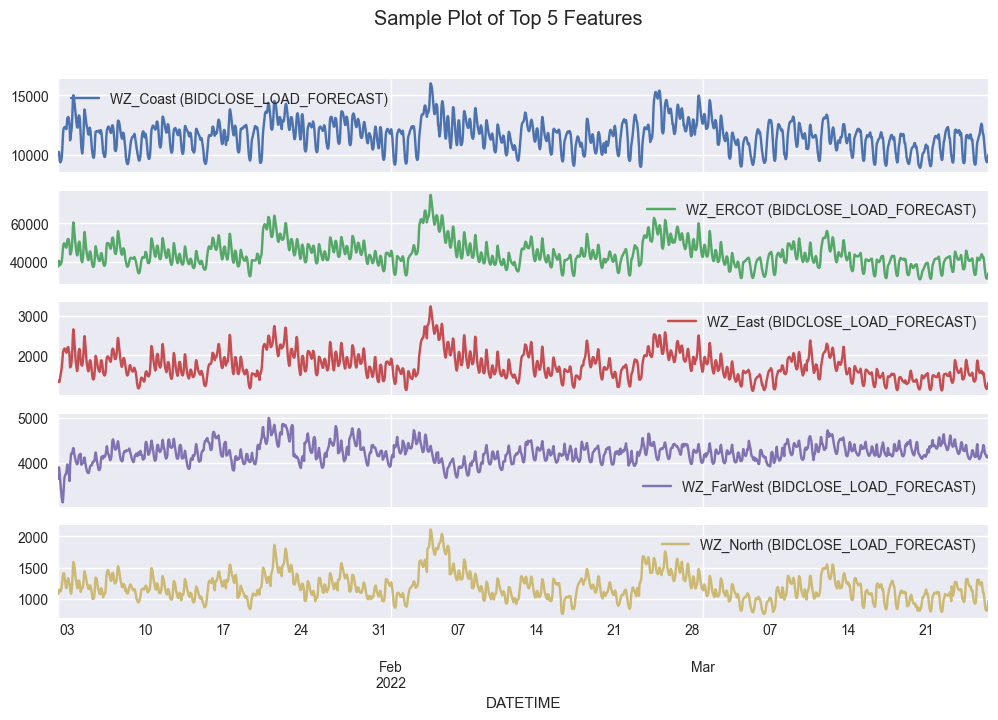

In [147]:
df_features_pre_pca.iloc[:2000, :5].plot(subplots=True, figsize = (12,7), 
                                        title='Sample Plot of Top 5 Features')
plt.show()

### Calculate Lagged Features
Lagged Features are simply the value of the feature 'n' intervals in the _past_.  It's possible that a lagged versions of features may have more predictive power than the original non-lagged feature.  Additional lagged feautures are created now after reducing total feature count in the initial PCA process.  PCA will tend to eliminate features that seem to be a near duplicate of another feature (and effectively could be represented by the other feature), which is what lagged variables resemble.  Still, it's possible that a lagged version of a variable is a better predictor than the original variable, so why not try?

In [148]:
# Example of lagged time series
df[cols_target[0]].to_frame().assign(lag_1=df[cols_target[0]].shift(1),
                                    lag_2=df[cols_target[0]].shift(2)).head(4)

HB_NORTH (DALMP)  lag_1  lag_2
DATETIME                                                 
2022-01-01 07:00:00+00:00             33.41    NaN    NaN
2022-01-01 08:00:00+00:00             25.22  33.41    NaN
2022-01-01 09:00:00+00:00             22.91  25.22  33.41
2022-01-01 10:00:00+00:00             18.41  22.91  25.22

#### Create df_lagged containing lagged versions of all features in cols_post_pca

In [149]:
lags = [1,2,3]
# lags = [1]
# create df_features to hold lagged series of original df data.
# df_lagged = pd.DataFrame(index=df.index)
df_features_pre_pca2 = pd.DataFrame(index=df.index)
# for col_ in df_features.index:
for col_ in cols_post_pca:
    for lag in lags:
#         df_lagged[f'{col_}_lag_{lag}'] = df[col_].shift(lag)
        df_features_pre_pca2[f'{col_}_lag_{lag}'] = df_features_pre_pca[col_].shift(lag)

In [150]:
# df_lagged.head(5).isna().sum(1).diff()

<Axes: xlabel='DATETIME'>

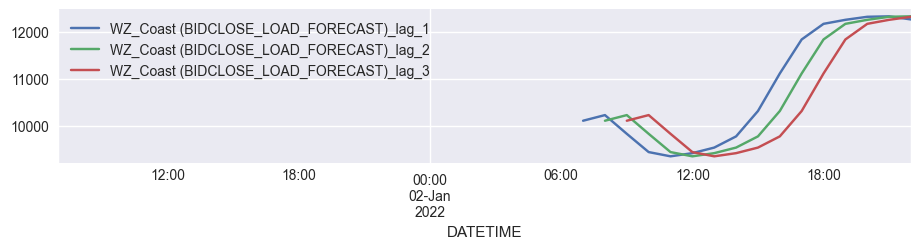

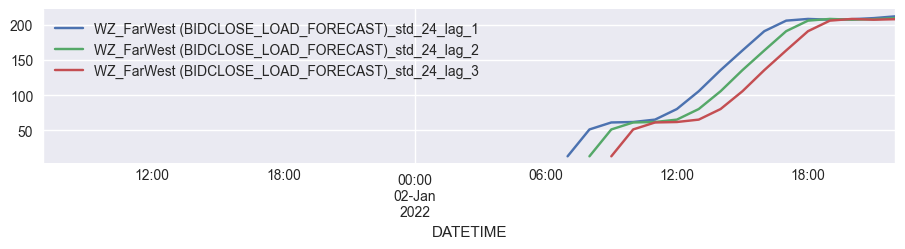

In [151]:
df_features_pre_pca2.iloc[:, :len(lags)].head(40).plot(figsize=(11,2))
df_features_pre_pca2.iloc[:, -len(lags):].head(40).plot(figsize=(11,2))

#### How Many Lagged Features are there?

In [152]:
n_features_ts_total = sum([x.columns.nunique() for x in dfs_ts_features])
n_features_ts_total = df_features_pre_pca2.shape[1]
print(f'There are {n_features_ts_total:,} Unique Features available '
      f'for {df_features_pre_pca2.index.shape[0]:,} time intervals')

There are 180 Unique Features available for 5,519 time intervals


#### Perform Second Principal Component Analysis - cols_post_pca & lagged cols_post_pca
This is the second use of PCA, this time applied to the new lagged features.  Note this is for linear relationships.  Non-linear PCA is not performed here.
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [153]:
df_features_pre_pca[cols_post_pca].join(df_features_pre_pca2)

WZ_Coast (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                       
2022-01-02 06:00:00+00:00                         10113.9004   
2022-01-02 07:00:00+00:00                         10234.0283   
2022-01-02 08:00:00+00:00                          9835.0029   
2022-01-02 09:00:00+00:00                          9445.7637   
2022-01-02 10:00:00+00:00                          9355.4541   
...                                                      ...   
2022-08-19 01:00:00+00:00                         17824.6992   
2022-08-19 02:00:00+00:00                         17434.3008   
2022-08-19 03:00:00+00:00                         16821.0996   
2022-08-19 04:00:00+00:00                         15956.9004   
2022-08-19 05:00:00+00:00                         15032.0000   

                           WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                       
2022-01-02 06:00:00+00:00                         37541.4701   
2022-01-02 07:00:00+00:00                         40474.6773   
2022-01-02 08:00:00+00:00                         39272.0467   
2022-01-02 09:00:00+00:00                         38530.8650   
2022-01-02 10:00:00+00:00                         38327.1850   
...                                                      ...   
2022-08-19 01:00:00+00:00                         66123.3203   
2022-08-19 02:00:00+00:00                         64306.1697   
2022-08-19 03:00:00+00:00                         62122.4999   
2022-08-19 04:00:00+00:00                         58237.7999   
2022-08-19 05:00:00+00:00                         54260.6896   

                           WZ_East (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                      
2022-01-02 06:00:00+00:00                         1359.5601   
2022-01-02 07:00:00+00:00                         1330.0509   
2022-01-02 08:00:00+00:00                         1333.0690   
2022-01-02 09:00:00+00:00                         1414.0864   
2022-01-02 10:00:00+00:00                         1461.7085   
...                                                     ...   
2022-08-19 01:00:00+00:00                         2423.1001   
2022-08-19 02:00:00+00:00                         2361.8899   
2022-08-19 03:00:00+00:00                         2269.7400   
2022-08-19 04:00:00+00:00                         2105.7700   
2022-08-19 05:00:00+00:00                         1934.1400   

                           WZ_FarWest (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                         
2022-01-02 06:00:00+00:00                            3642.8799   
2022-01-02 07:00:00+00:00                            3899.4763   
2022-01-02 08:00:00+00:00                            3830.4451   
2022-01-02 09:00:00+00:00                            3717.0901   
2022-01-02 10:00:00+00:00                            3572.9658   
...                                                        ...   
2022-08-19 01:00:00+00:00                            5083.8301   
2022-08-19 02:00:00+00:00                            5064.5200   
2022-08-19 03:00:00+00:00                            5067.2598   
2022-08-19 04:00:00+00:00                            4939.5898   
2022-08-19 05:00:00+00:00                            4822.8301   

                           WZ_North (BIDCLOSE_LOAD_FORECAST)  \
DATETIME                                                       
2022-01-02 06:00:00+00:00                          1077.0699   
2022-01-02 07:00:00+00:00                          1146.5392   
2022-01-02 08:00:00+00:00                          1132.9419   
2022-01-02 09:00:00+00:00                          1124.5493   
2022-01-02 10:00:00+00:00                          1118.5973   
...                                                      ...   
2022-08-19 01:00:00+00:00                          1667.6200   
2022-08-19 02:00:00+00:00                          1606.4800   
2022-08-19 03:00:00+00:00                 

In [154]:
# create single df containing features selected from first PCA process + their lagged versions.
df_features_pca2 = df_features_pre_pca[cols_post_pca].join(df_features_pre_pca2).dropna()
# getting all values as a matrix of dataframe 
# X = df_features_pre_pca2.dropna().values 
X = df_features_pca2.values 
sc = StandardScaler() # initiate StandardScaler
X_std2 = sc.fit_transform(X) # standardize the data

In [155]:
pca2 = PCA()
X_pca2 = pca2.fit(X_std2)

#### Visualize Explained Variance of each Feature

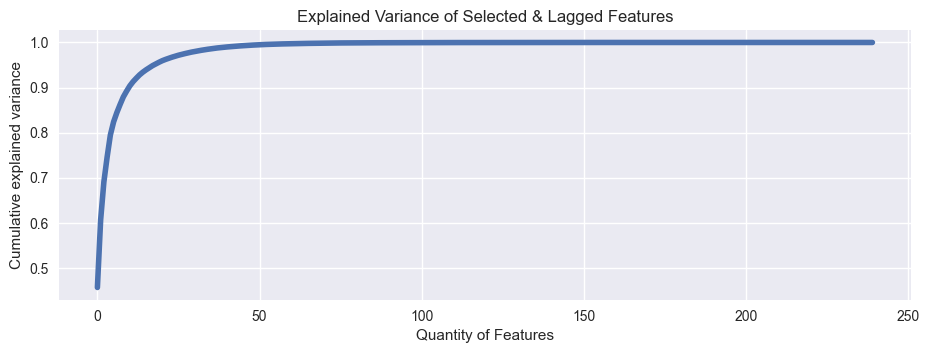

In [156]:
plt.figure(figsize = (11,3.5))
plt.plot(np.cumsum(X_pca2.explained_variance_ratio_), lw=4)
plt.xlabel('Quantity of Features')
plt.ylabel('Cumulative explained variance');
plt.title('Explained Variance of Selected & Lagged Features')
plt.show()

#### Store Explained Variance by Feature in df_pca2
Use this df to identify significance by feature

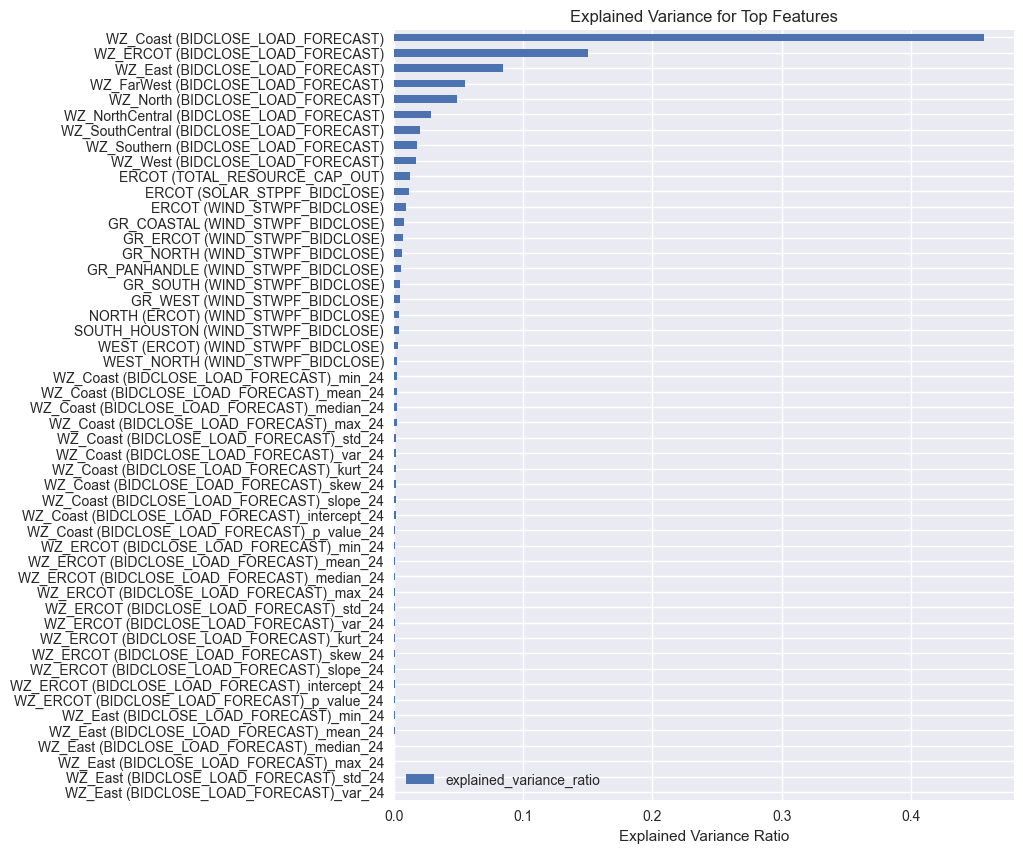

In [157]:
df_pca2 = pd.DataFrame(index=df_features_pca2.columns, 
                     data={'explained_variance_ratio': X_pca2.explained_variance_ratio_})\
                        .sort_values('explained_variance_ratio', ascending=False)
df_pca2.head(50)[::-1].plot.barh(figsize=(8,10), title='Explained Variance for Top Features',
                               )
plt.xlabel('Explained Variance Ratio')
plt.show()

In [158]:
# # df_pca2 = pd.DataFrame(index=df_features_pre_pca2.columns, 
# #                      data={'explained_variance_ratio': X_pca2.explained_variance_ratio_})\
# #                         .sort_values('explained_variance_ratio', ascending=False)
# df_pca2.head(10)[::-1].plot.barh(figsize=(8,3), title='Explained Variance for Top 10 Features',
#                                )
# plt.xlabel('Explained Variance Ratio')
# plt.show()

#### Select Features that account for min_var_explained Variance

In [159]:
# what is the minimum cumulative explained variance needed?  this is a question of accuracy
# (higher value) vs. speed and/or overfitting/robust performance (lower value).
min_var_explained = 0.95

In [160]:
df_pca2['cumulative_explained_variance_ratio'] = df_pca2['explained_variance_ratio'].cumsum()
df_pca2.head(5)

explained_variance_ratio  \
WZ_Coast (BIDCLOSE_LOAD_FORECAST)                    0.456700   
WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)                    0.149964   
WZ_East (BIDCLOSE_LOAD_FORECAST)                     0.084292   
WZ_FarWest (BIDCLOSE_LOAD_FORECAST)                  0.054986   
WZ_North (BIDCLOSE_LOAD_FORECAST)                    0.049048   

                                     cumulative_explained_variance_ratio  
WZ_Coast (BIDCLOSE_LOAD_FORECAST)                               0.456700  
WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)                               0.606664  
WZ_East (BIDCLOSE_LOAD_FORECAST)                                0.690956  
WZ_FarWest (BIDCLOSE_LOAD_FORECAST)                             0.745942  
WZ_North (BIDCLOSE_LOAD_FORECAST)                               0.794990

In [161]:
n_features_min_var = df_pca2['cumulative_explained_variance_ratio'].lt(min_var_explained).sum()
print(f'{n_features_min_var:} features explain {round(100*min_var_explained,1)}% of all variance')

18 features explain 95.0% of all variance


In [162]:
cols_post_pca2 = df_pca2.index.tolist()[:n_features_min_var]
cols_post_pca2

['WZ_Coast (BIDCLOSE_LOAD_FORECAST)',
 'WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)',
 'WZ_East (BIDCLOSE_LOAD_FORECAST)',
 'WZ_FarWest (BIDCLOSE_LOAD_FORECAST)',
 'WZ_North (BIDCLOSE_LOAD_FORECAST)',
 'WZ_NorthCentral (BIDCLOSE_LOAD_FORECAST)',
 'WZ_SouthCentral (BIDCLOSE_LOAD_FORECAST)',
 'WZ_Southern (BIDCLOSE_LOAD_FORECAST)',
 'WZ_West (BIDCLOSE_LOAD_FORECAST)',
 'ERCOT (TOTAL_RESOURCE_CAP_OUT)',
 'ERCOT (SOLAR_STPPF_BIDCLOSE)',
 'ERCOT (WIND_STWPF_BIDCLOSE)',
 'GR_COASTAL (WIND_STWPF_BIDCLOSE)',
 'GR_ERCOT (WIND_STWPF_BIDCLOSE)',
 'GR_NORTH (WIND_STWPF_BIDCLOSE)',
 'GR_PANHANDLE (WIND_STWPF_BIDCLOSE)',
 'GR_SOUTH (WIND_STWPF_BIDCLOSE)',
 'GR_WEST (WIND_STWPF_BIDCLOSE)']

In [163]:
df_features_pca2[cols_post_pca2].join(df[cols_target]).corr(method='spearman')[cols_target]\
    .sort_values(by=cols_target, ascending=[False, False])

HB_NORTH (DALMP)  HB_NORTH (RTLMP)
HB_NORTH (DALMP)                                  1.000000          0.841982
HB_NORTH (RTLMP)                                  0.841982          1.000000
WZ_Coast (BIDCLOSE_LOAD_FORECAST)                 0.795194          0.718036
WZ_Southern (BIDCLOSE_LOAD_FORECAST)              0.790688          0.716641
WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)                 0.775161          0.704363
WZ_SouthCentral (BIDCLOSE_LOAD_FORECAST)          0.775072          0.704209
WZ_NorthCentral (BIDCLOSE_LOAD_FORECAST)          0.697880          0.638373
WZ_West (BIDCLOSE_LOAD_FORECAST)                  0.691183          0.603902
WZ_East (BIDCLOSE_LOAD_FORECAST)                  0.690551          0.615349
WZ_FarWest (BIDCLOSE_LOAD_FORECAST)               0.686552          0.670134
WZ_North (BIDCLOSE_LOAD_FORECAST)                 0.616386          0.571435
ERCOT (SOLAR_STPPF_BIDCLOSE)                      0.327850          0.233879
GR_COASTAL (WIND_STWPF_BIDCLOSE)                  0.130265          0.120907
GR_SOUTH (WIND_STWPF_BIDCLOSE)                   -0.060764         -0.043135
GR_ERCOT (WIND_STWPF_BIDCLOSE)                   -0.290893         -0.264709
ERCOT (WIND_STWPF_BIDCLOSE)                      -0.290893         -0.264709
ERCOT (TOTAL_RESOURCE_CAP_OUT)                   -0.327764         -0.347627
GR_NORTH (WIND_STWPF_BIDCLOSE)                   -0.342731         -0.320527
GR_PANHANDLE (WIND_STWPF_BIDCLOSE)               -0.348115         -0.326895
GR_WEST (WIND_STWPF_BIDCLOSE)                    -0.355148         -0.319382

#### Save df_lagged to disk - Not Used

In [164]:
# file_lagged = data_dir / 'features_lagged.csv'
# print(file_lagged)
# df_lagged.to_csv(file_lagged)
# assert file_lagged.is_file()

### Inspect Correlations of Selected Features

#### Correlation with 'HB_NORTH (DALMP)'

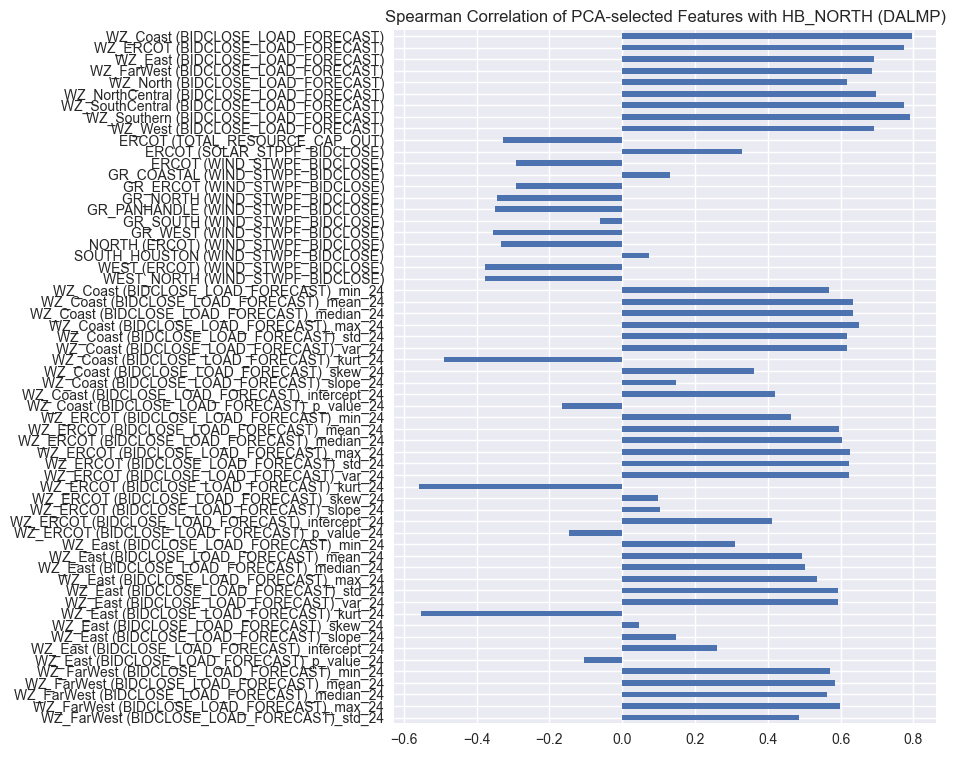

In [165]:
col_target_ = cols_target[0]
df_features_pre_pca[cols_post_pca].corrwith(df.loc[df_features_pre_pca.index,
               col_target_], method='spearman').loc[cols_post_pca[::-1]].plot.barh(figsize=(7,9))
plt.title(f'Spearman Correlation of PCA-selected Features with {col_target_}')
plt.show()

#### Correlation with 'HB_NORTH (RTLMP)'

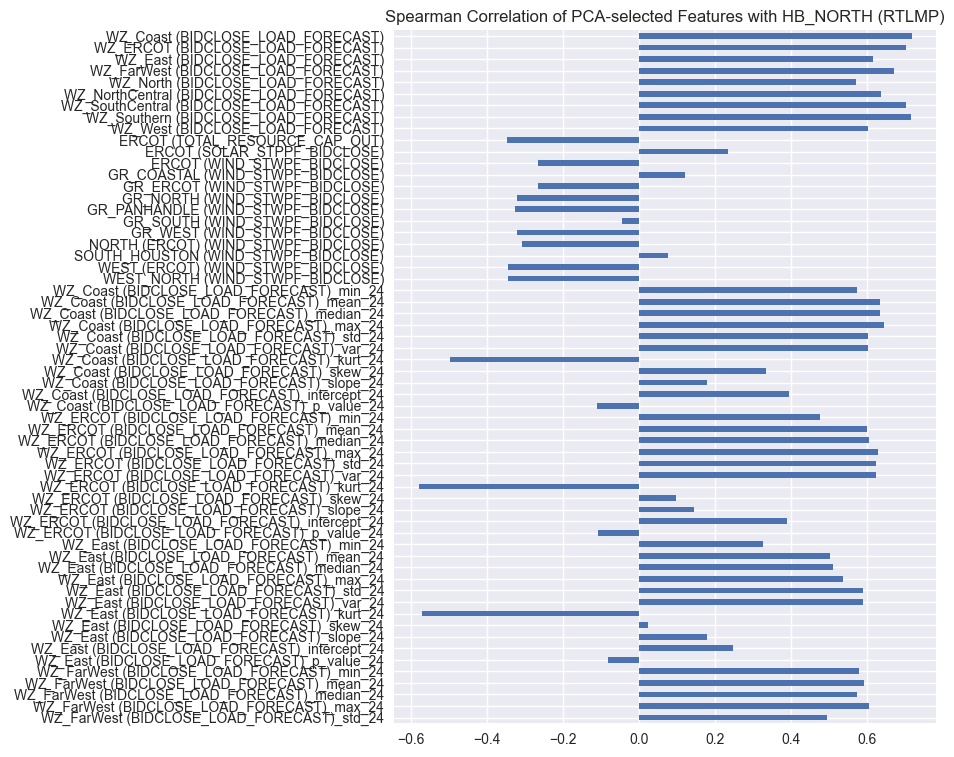

In [166]:
col_target_ = cols_target[1]
df_features_pre_pca[cols_post_pca].corrwith(df.loc[df_features_pre_pca.index,
               col_target_], method='spearman').loc[cols_post_pca[::-1]].plot.barh(figsize=(7,9))
plt.title(f'Spearman Correlation of PCA-selected Features with {col_target_}')
plt.show()

#### Correlation with 'HB_NORTH (DALMP)' including Lagged features

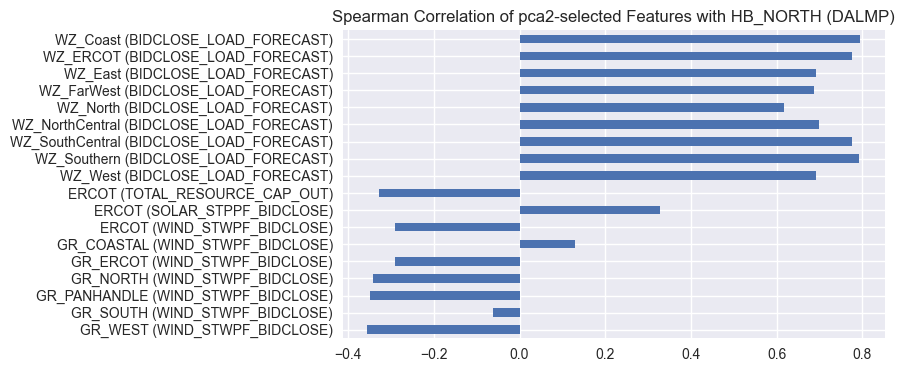

In [167]:
col_target_ = cols_target[0]
df_features_pca2[cols_post_pca2].corrwith(df.loc[df_features_pre_pca2.index,
               col_target_], method='spearman').loc[cols_post_pca2[::-1]].plot.barh(figsize=(7,4))
plt.title(f'Spearman Correlation of pca2-selected Features with {col_target_}')
plt.show()

#### Correlation with 'HB_NORTH (RTLMP)'

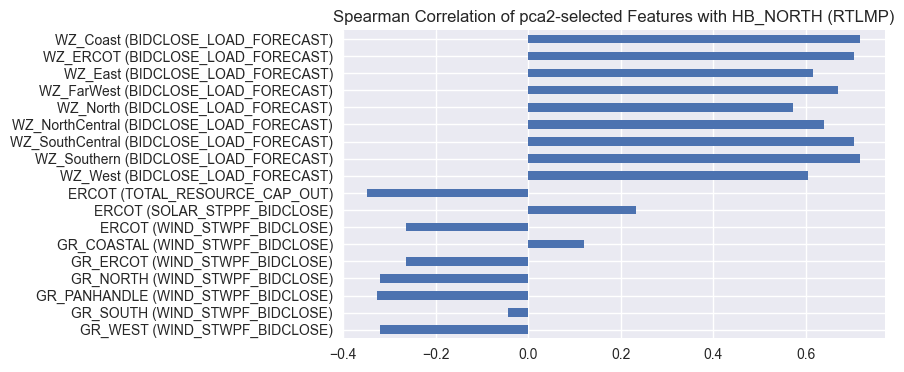

In [168]:
col_target_ = cols_target[1]
df_features_pca2[cols_post_pca2].corrwith(df.loc[df_features_pre_pca2.index,
               col_target_], method='spearman').loc[cols_post_pca2[::-1]].plot.barh(figsize=(7,4))
plt.title(f'Spearman Correlation of pca2-selected Features with {col_target_}')
plt.show()

#### Create df_ts_select containing only Significant Features

In [169]:
# df_select = df_features_pre_pca[cols_post_pca].copy()
df_select = df_features_pre_pca[cols_post_pca2].copy()

#### Add Target Columns to df_select
This dataset will serve as basis for training for remainder of process

In [170]:
df_select = df_select.join(df[cols_target])

#### Save df_select and df_features to disk

In [171]:
file_ts_select = data_dir / 'ts_select.csv'
print(file_ts_select)
df_select.to_csv(file_ts_select)
assert file_ts_select.is_file()

C:\Users\user\OneDrive\python_envs\ERCOT_electricity_price_forecast\data\ts_select.csv


In [172]:
file_features_select = data_dir / 'features_select.csv'
print(file_features_select)
df_features.to_csv(file_features_select)
assert file_features_select.is_file()

C:\Users\user\OneDrive\python_envs\ERCOT_electricity_price_forecast\data\features_select.csv


# END

Proceed to 3 - Stationarity and Seasonality